# Machine learning-based framework for prospectivity mapping of critical minerals

### Ehsan Farahbakhsh<sup>1</sup>, Jack Maughan<sup>2</sup>, R. Ditmar M&uuml;ller<sup>1</sup>

<sup>1</sup>*EarthByte Group, School of Geosciences, University of Sydney, NSW 2006, Australia*

<sup>2</sup>*Datarock Pty Ltd., Level 3, 31 Queen Street, VIC 3000, Australia*

This notebook enables the user to create a prospectivity map of critical minerals in South Australia, particularly the Gawler Craton. It comprises two main sections; in the first section, the available datasets are visualised, and in the second section, a variety of machine learning algorithms are applied to create a prospectivity map.

### Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import namedtuple
import contextily as cx
import csv
import functools
import geopandas as gpd
import glob
from ipywidgets import interact
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
from numpy import genfromtxt

from osgeo import gdal
from osgeo import osr
import os
import pandas as pd
from pprint import pprint
from pulearn import BaggingPuClassifier
import rioxarray as rxr
from scipy import interp
import scipy.spatial
from scipy.spatial import distance_matrix
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import mapping
import shapely.strtree
from skimage import exposure, util
from skimage.feature import graycomatrix, graycoprops
from tqdm.notebook import tqdm

import sklearn
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, plot_roc_curve, roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

### Target commodity and mineralisation type

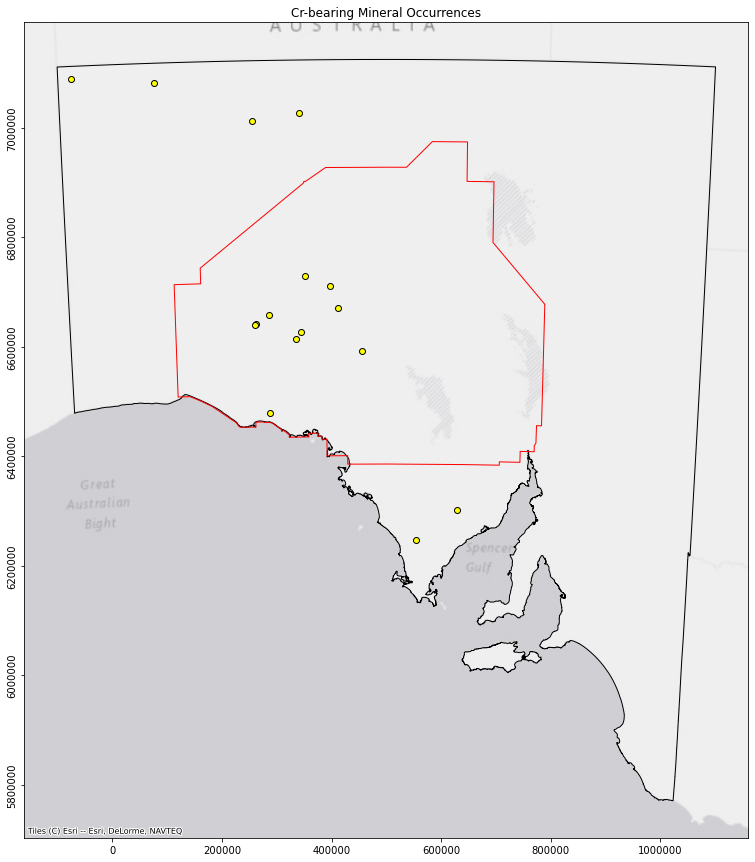

In [2]:
# uncomment the target commodity
# commodity = 'Co'
commodity = 'Cr'
# commodity = 'Ni'

# uncomment the relevant shapefile
# mines_gda94 = gpd.read_file('./Datasets/Mineral occurrences/cobalt.shp')
mines_gda94 = gpd.read_file('./Datasets/Mineral occurrences/chromium.shp')
# mines_gda94 = gpd.read_file('./Datasets/Mineral occurrences/nickel.shp')
mines = mines_gda94.to_crs('epsg:7853')

# read boundaries
sa_boundary_gda94 = gpd.read_file('./Datasets/Frames/SA_Frame_GDA94.shp')
sa_boundary = sa_boundary_gda94.to_crs('epsg:7853')
gc_boundary_gda94 = gpd.read_file('./Datasets/Frames/GC_Frame_GDA94.shp')
gc_boundary = gc_boundary_gda94.to_crs('epsg:7853')

# target mineralisation types
cox_class = ['Deposits related to mafic and ultramafic intrusions in stable environments',
             'Deposits related to mafic-ultramafic rocks in unstable areas']

# plot the mineral occurrences
fig, ax = plt.subplots(figsize=(15, 15))
mines.plot(ax=ax, edgecolor='black', color='yellow')
sa_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
gc_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
# Esri: WorldStreetMap, DeLorme, WorldTopoMap, WorldImagery, WorldTerrain, WorldShadedRelief, WorldPhysical, OceanBasemap,
# NatGeoWorldMap, WorldGrayCanvas
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.set_title(f'{commodity}-bearing Mineral Occurrences')
plt.show()

### Mineralisation types

In [3]:
# extract all mineralisation types
mineralisation_types = mines.COX_CLASS.unique()
mineralisation_types.sort()

# count and print the number of each mineralisation type
print(mines.COX_CLASS.value_counts())

@interact(mineralisation_type=mineralisation_types)
def show_map(mineralisation_type):
    fig, ax = plt.subplots(figsize=(15, 15))
    data = mines[mines.COX_CLASS==mineralisation_type]
    data.plot(ax=ax, edgecolor='black', color='yellow')
    sa_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
    gc_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
    cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    ax.set_title(mineralisation_type)
    plt.show()

Deposits related to mafic-ultramafic rocks in unstable areas                  7
Deposits related to mafic and ultramafic intrusions in stable environments    4
Deposits related to surficial processes and unconformities                    3
Deposits related to regionally metamorphosed rocks                            1
Komatiitic Ni-Cu                                                              1
Name: COX_CLASS, dtype: int64


interactive(children=(Dropdown(description='mineralization_type', options=('Deposits related to mafic and ultr…

### Vector datasets

#### Electrical resistivity

There are different resistivity layers available from the depth of 10 to 300 km.

In [ ]:
# read the resistivity dataset
resistivity_raw = gpd.read_file('./Datasets/Resistivity/AusLAMP_MT_Gawler.shp')
resistivity_raw = resistivity_raw.to_crs('epsg:7853')
resistivity_gc = resistivity_raw.clip(gc_boundary)
resistivity_gc['X'] = resistivity_gc['geometry'].x
resistivity_gc['Y'] = resistivity_gc['geometry'].y

unique_depths = resistivity_gc.Depth_m_.unique()
unique_depths = -np.sort(-unique_depths)

resistivity_data = []
for i in unique_depths:
    resistivity_data.append(resistivity_gc[resistivity_gc.Depth_m_==i].values)

resistivity_data = np.array(resistivity_data)
resistivity_x = resistivity_data[0, :, 5]
resistivity_y = resistivity_data[0, :, 6]

@interact(depth=unique_depths)
def show_map(depth):
    fig, ax = plt.subplots(figsize=(15, 15))
    cb = ax.scatter(resistivity_x, resistivity_y, c=resistivity_gc[resistivity_gc.Depth_m_==depth].Res_Log, cmap='Spectral_r')
    gc_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
    cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    ax.set_title('Resistivity at the Depth of '+str(depth))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Resistivity', cax=cax)
    plt.show()

#### Faults and dykes

Four sets of linear features are available, including Archaean-Early Mesoproterozoic faults, Late Mesoproterozoic faults, Middle Mesoproterozoic faults, and Neoproterozoic-Ordovician faults that have been merged into a single file.

In [ ]:
faults = gpd.read_file('./Datasets/Polylines/Faults.shp')
faults = faults.to_crs('epsg:7853')
faults = faults.clip(gc_boundary)
fig, ax = plt.subplots(figsize=(15, 15))
faults.plot(ax=ax, color=None, edgecolor='black', linewidth=1)
gc_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.set_title('Faults')
plt.show()

#### Geological provinces

There are a number of geological provinces in South Australia including Archaean to early Mesoproterozoic, Cainozoic, Cambrian to late Carboniferous, Jurassic to Cretaceous, Late Carboniferous to Triassic, Middle to late Mesoproterozoic, and Neoproterozoic provinces.

In [ ]:
province_filenames = [
    './Datasets/Polygons/Archaean to early Mesoproterozoic geological provinces_shp\Archaean to early Mesoproterozoic geological provinces.shp',
    './Datasets/Polygons/Cainozoic geological provinces_shp\Cainozoic geological provinces.shp',
    './Datasets/Polygons/Cambrian to late Carboniferous geological provinces_shp/Cambrian to late Carboniferous geological provinces.shp',
    './Datasets/Polygons/Jurassic to Cretaceous geolgocial provinces_shp/Jurassic to Cretaceous geolgocial provinces.shp',
    './Datasets/Polygons/Late Carboniferous to Triassic geological provinces_shp/Late Carboniferous to Triassic geological provinces.shp',
    './Datasets/Polygons/Middle to late Mesoproterozoic geoglocial provinces_shp/Middle to late Mesoproterozoic geoglocial provinces.shp',
    './Datasets/Polygons/Neoproterozoic geolgoical provinces_shp/Neoproterozoic geolgoical provinces.shp'
    ]

@interact(dataset=province_filenames)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    data = data.to_crs('epsg:7853')
    data = data.clip(gc_boundary)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
    gc_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
    cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    ax.set_title('Geological Provinces')
    plt.show()

#### Rock units

In [ ]:
geology_filenames = [
    './Datasets/polygons/Archaean - Early Mesoproterozoic polygons_shp/Archaean - Early Mesoproterozoic polygons.shp',
    './Datasets/polygons/Late Mesoproterozoic polygons_shp/Late Mesoproterozoic polygons.shp',
    './Datasets/polygons/Middle Mesoproterozoic polygons_shp/Middle Mesoproterozoic polygons.shp',
    './Datasets/polygons/Neoproterozoic - Ordovician polygons_shp/Neoproterozoic - Ordovician polygons.shp'
    ]

@interact(dataset=geology_filenames)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    data = data.to_crs('epsg:7853')
    data = data.clip(gc_boundary)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
    gc_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
    cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    ax.set_title('Rock Units')
    plt.show()

### Raster datasets

#### Magnetic field intensity

In [ ]:
magnetic_filenames = [
    './Datasets/Magnetic/SA_TMI_ERS_GDA2020/SA_TMI_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_1VD_ERS_GDA2020/SA_TMI_VRTP_1VD_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_AGC_ERS_GDA2020/SA_TMI_VRTP_AGC_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_AS_ERS_GDA2020/SA_TMI_VRTP_AS_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_BigE_ERS_GDA2020/SA_TMI_VRTP_BigE_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_BigT_ERS_GDA2020/SA_TMI_VRTP_BigT_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_CAUCHY_3rd_ERS_GDA2020/SA_TMI_VRTP_CAUCHY_3rd_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_ERS_GDA2020/SA_TMI_VRTP_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_PsuedoGrav_ERS_GDA2020/SA_TMI_VRTP_PsuedoGrav_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_Tilt_ERS_GDA2020/SA_TMI_VRTP_Tilt_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_Tz_ERS_GDA2020/SA_TMI_VRTP_TZ_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_Tzz_ERS_GDA2020/SA_TMI_VRTP_Tzz_GDA94.tif'
    ]

@interact(dataset=magnetic_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(sa_boundary.crs)
    raster_clipped = raster.rio.clip(gc_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = gc_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    gc_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Total magnetic intensity (nT)', cax=cax)
    plt.show()

#### Gravity

In [ ]:
gravity_filenames = [
    './Datasets/Gravity/SA_GRAV_1VD_ERS/SA_GRAV_1VD_ONSHORE_GDA94.tif',
    './Datasets/Gravity/SA_GRAV_ERS/SA_GRAV_ONSHORE_GDA94.tif',
    './Datasets/Gravity/SA_GRAV_RESIDUAL_ERS/SA_GRAV_UC1000_RESIDUAL_ONSHORE_GDA94.tif'
    ]

@interact(dataset=gravity_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(sa_boundary.crs)
    raster_clipped = raster.rio.clip(gc_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = gc_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))
    fig, ax = plt.subplots(figsize=(15, 15))
    gc_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Gravity (mGal)', cax=cax)
    plt.show()

#### Radiometric assay

In [ ]:
radiometric_filenames = [
    './Datasets/Radiometric/SA_RAD_DOSE_ERS/SA_RAD_DOSE.ers',     # Radiation dose rate
    './Datasets/Radiometric/SA_RAD_K_ERS/SA_RAD_K.ers',           # K concentration
    './Datasets/Radiometric/SA_RAD_TH_ERS/SA_RAD_TH.ers',         # Th concentration
    './Datasets/Radiometric/SA_RAD_U_ERS/SA_RAD_U.ers'            # U concentration
    ]

@interact(dataset=radiometric_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(sa_boundary.crs)
    raster_clipped = raster.rio.clip(gc_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = gc_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    gc_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Radiation dose rate', cax=cax)
    plt.show()

#### Remote sensing

In [ ]:
rs_filenames = [
    './Datasets/Remote Sensing/AlOH_GROUP_COMPOSITION_ECW/AlOH_group_composition_grayscale.tif',
    './Datasets/Remote Sensing/AlOH_GROUP_CONTENT_ECW/AlOH_group_content_grayscale.tif',
    './Datasets/Remote Sensing/FEOH_GROUP_CONTENT_ECW/FeOH_group_content_grayscale.tif',
    './Datasets/Remote Sensing/FERRIC_OXIDE_COMPOSITION_ECW/Ferric_oxide_composition_grayscale.tif',
    './Datasets/Remote Sensing/FERRIC_OXIDE_CONTENT_ECW/Ferric_oxide_content_grayscale.tif',
    './Datasets/Remote Sensing/FERROUS_IRON_CONTENT_IN_MGOH_ECW/Ferrous_iron_content_in_MgOH_grayscale.tif',
    './Datasets/Remote Sensing/FERROUS_IRON_INDEX_ECW/Ferrous_iron_index_grayscale.tif',
    './Datasets/Remote Sensing/GREEN_VEGATION_CONTENT_ECW/Green_vegetation_content_grayscale.tif',
    './Datasets/Remote Sensing/KAOLIN_GROUP_INDEX_ECW/Kaolin_group_index_grayscale.tif',
    './Datasets/Remote Sensing/MGOH_GROUP_COMPOSITION_ECW/MgOH_group_composition_grayscale.tif',
    './Datasets/Remote Sensing/MGOH_GROUP_CONTENT_ECW/MgOH_group_content_grayscale.tif',
    './Datasets/Remote Sensing/OPAQUE_INDEX_ECW/Opaque_index_grayscale.tif',
    './Datasets/Remote Sensing/QUARTZ INDEX_ECW/Quartz_index_grayscale.tif',
    './Datasets/Remote Sensing/SILICA INDEX_ECW/Silica_index_grayscale.tif'
]

@interact(dataset=rs_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(sa_boundary.crs)
    raster_clipped = raster.rio.clip(gc_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)
    raster_clipped = np.where(raster_clipped==raster_clipped[0,0], np.nan, raster_clipped)

    bounds = gc_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    gc_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Reflectance', cax=cax)
    plt.show()

#### Depth to basement and elevation

In [ ]:
depth_filenames = [
    './Datasets/Others/GDP00003/ArcGIS/SA_Cover_thickness_50m_GDA94_NoData.tif',
    './Datasets/Others/DEM-9S_ESRI/Data_9secDEM_D8/dem-9s_GDA94_SA_NoData.tif',
    './Datasets/Others/GDP00003/Grids/MagneticSourceCoverThickness_GDA94.tif',
    './Datasets/Others/GDP00003/Grids/SA_CoverThickness_400m_GDA94_NoData.tif',
    './Datasets/Others/GDP00003/Grids/MagneticSourceElevation_GDA94.tif'
    ]

@interact(dataset=depth_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(sa_boundary.crs)
    raster_clipped = raster.rio.clip(gc_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = gc_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    gc_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Cover thickness', cax=cax)
    plt.show()

### Extracting the coordinates of target mineral occurrences

In [4]:
def get_deposits(cox_class):
    deposit_x = []
    deposit_y = []
    deposit_num = 0
    
    for c in cox_class:
        deposits = mines[mines.COX_CLASS==c]
        deposit_num += deposits.shape[0]
    
        deposit_x_ = deposits.geometry.x
        deposit_y_ = deposits.geometry.y
    
        deposit_x.extend(pd.Series.tolist(deposit_x_))
        deposit_y.extend(pd.Series.tolist(deposit_y_))
    
    return deposit_num, deposit_x, deposit_y

# export the coordinates to a CSV file
coords_file = f'./{commodity}/training_data_{commodity}_deposit_coords.csv'

if os.path.isfile(coords_file):
    print('The coordinates of deposits already exist.')
    deposit_coords = pd.read_csv(coords_file, index_col=False)
    deposit_num = int(deposit_coords.shape[0])
    deposit_x = pd.Series.tolist(deposit_coords['X'])
    deposit_y = pd.Series.tolist(deposit_coords['Y'])
else:
    deposit_num, deposit_x, deposit_y = get_deposits(cox_class)
    deposit_coords = pd.DataFrame(deposit_x, columns=['X'])
    deposit_coords['Y'] = deposit_y
    deposit_label = [1]*deposit_num
    deposit_coords['label'] = deposit_label
    deposit_coords.to_csv(coords_file, index=False)
    print(f'The coordinates of deposits have been saved to {coords_file}.')

The coordinates of deposits already exist.


### Training data file

The training data file containing features and labels is generated. The rows in this file represent samples and each column represents a feature. A specific function has been defined for each type of features to extract feature values at desired points that involve mineral occurrences, random, and target locations.

#### Faults/dykes and electrical resistivity

In [5]:
# calculate the distance from a point to linear features like faults and dykes
def get_fault_distance(xs, ys):
    faults = gpd.read_file('./Datasets/Polylines/Faults.shp')
    faults = faults.to_crs('epsg:7853')
    # construct a spatial tree considering the geometries of all faults/dykes
    fault_tree = shapely.strtree.STRtree(faults.geometry)
    
    points = [Point(x, y) for x, y in zip(xs, ys)]
    distance_to_faults = []
    for p in points:
        distance_to_faults.append(round(p.distance(fault_tree.nearest(p)), 2))
    return pd.DataFrame(np.array(distance_to_faults).T, columns=['Faults'])

# calculate the distance from a point to contacts
def get_contact_distance(xs, ys):
    polygon_filenames = [
        './Datasets/polygons/Archaean - Early Mesoproterozoic polygons_shp/Archaean - Early Mesoproterozoic polygons.shp',
        './Datasets/polygons/Late Mesoproterozoic polygons_shp/Late Mesoproterozoic polygons.shp',
        './Datasets/polygons/Middle Mesoproterozoic polygons_shp/Middle Mesoproterozoic polygons.shp',
        './Datasets/polygons/Neoproterozoic - Ordovician polygons_shp/Neoproterozoic - Ordovician polygons.shp',
        './Datasets/Polygons/Archaean to early Mesoproterozoic geological provinces_shp\Archaean to early Mesoproterozoic geological provinces.shp',
        './Datasets/Polygons/Cainozoic geological provinces_shp\Cainozoic geological provinces.shp',
        './Datasets/Polygons/Cambrian to late Carboniferous geological provinces_shp/Cambrian to late Carboniferous geological provinces.shp',
        './Datasets/Polygons/Jurassic to Cretaceous geolgocial provinces_shp/Jurassic to Cretaceous geolgocial provinces.shp',
        './Datasets/Polygons/Late Carboniferous to Triassic geological provinces_shp/Late Carboniferous to Triassic geological provinces.shp',
        './Datasets/Polygons/Middle to late Mesoproterozoic geoglocial provinces_shp/Middle to late Mesoproterozoic geoglocial provinces.shp',
        './Datasets/Polygons/Neoproterozoic geolgoical provinces_shp/Neoproterozoic geolgoical provinces.shp'
        ]

    contact_trees = []
    for polygon_file in polygon_filenames:
        data = gpd.read_file(polygon_file)
        data = data.to_crs('epsg:7853')
        data = data.boundary
        # construct a spatial tree considering the geometries of all contacts
        contact_trees.append(shapely.strtree.STRtree(data.geometry))
    
    points = [Point(x, y) for x, y in zip(xs, ys)]
    distance_to_contacts = []
    column_names = []
    for idx, tree in enumerate(contact_trees):
        distance_to_contacts.append([round(p.distance(tree.nearest(p)), 2) for p in points])
        column_names.append(os.path.splitext(os.path.basename(polygon_filenames[idx]))[0]+'_Contact')
    return pd.DataFrame(np.array(distance_to_contacts).T, columns=column_names)

# preprocess the resistivity data
resistivity_pc_file = './Datasets/Resistivity/Resistivity_PCs.csv'

if os.path.isfile(resistivity_pc_file):
    print('The principal components of resistivity data already exist.')
    selected_components = pd.read_csv(resistivity_pc_file, index_col=False)
else:
    unique_depths = resistivity_raw.Depth_m_.unique()
    unique_depths = -np.sort(-unique_depths)

    resistivity_data = []
    for i in unique_depths:
        resistivity_data.append(resistivity_raw[resistivity_raw.Depth_m_==i].values)

    resistivity_data = np.array(resistivity_data)
    resistivity_features = np.zeros((resistivity_data.shape[1], resistivity_data.shape[0]))
    
    for i in range(resistivity_data.shape[0]):
        resistivity_features[:, i] = resistivity_data[i, :, 3]
        
    scaler = StandardScaler()
    scaler.fit(resistivity_features)
    resistivity_features = scaler.transform(resistivity_features)

    # pca
    pca = PCA()
    components = pca.fit_transform(resistivity_features)
    var_ratio = pca.explained_variance_ratio_
    var_sum = 0

    for i in range(len(var_ratio)):
        if var_sum >= 0.99:
            break
        else:
            var_sum += var_ratio[i]

    selected_components = components[:, :i]
    resistivity_column_names = [f'Res_C{c}' for c in list(range(1, i+1))]
    selected_components = pd.DataFrame(selected_components, columns=resistivity_column_names)
    selected_components.to_csv(resistivity_pc_file, columns=resistivity_column_names, index=False)

    print(f'The principal components of resistivity data have been saved to {resistivity_pc_file}.')

# extract the value of the closest point
def get_resistivity_data(xs, ys):
    resistivity_raw['X'] = resistivity_raw['geometry'].x
    resistivity_raw['Y'] = resistivity_raw['geometry'].y

    unique_depths = resistivity_raw.Depth_m_.unique()
    unique_depths = -np.sort(-unique_depths)

    resistivity_data = []
    for i in unique_depths:
        resistivity_data.append(resistivity_raw[resistivity_raw.Depth_m_==i].values)

    resistivity_data = np.array(resistivity_data)
    resistivity_x = resistivity_data[0, :, 5]
    resistivity_y = resistivity_data[0, :, 6]
    
    resistivity_tree = scipy.spatial.cKDTree(np.c_[resistivity_x, resistivity_y])
    
    # query the tree for target points
    _, indexes = resistivity_tree.query(np.c_[xs, ys], k=1)
    resistivity_points = selected_components.to_numpy()[indexes, :]
    return pd.DataFrame(resistivity_points, columns=selected_components.columns)

# concatenate and export the features generated using the functions above
def get_vector_data(xs, ys):
    fault_distance_df = get_fault_distance(xs, ys)
    contact_distance_df = get_contact_distance(xs, ys)
    resistivity_data_df = get_resistivity_data(xs, ys)
    
    data = pd.concat([fault_distance_df, contact_distance_df, resistivity_data_df], axis=1).reset_index(drop=True)
    return data

vector_file = f'./{commodity}/training_data_{commodity}_deposit_vector.csv'

if os.path.isfile(vector_file):
    print('The vector dataset (deposits) already exists.')
    deposit_vector_data = pd.read_csv(vector_file, index_col=False)
else:
    deposit_vector_data = get_vector_data(deposit_x, deposit_y)
    deposit_vector_data = deposit_vector_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_vector_data.to_csv(vector_file, index=False)
    print(f'The vector dataset (deposits) has been saved to {vector_file}.')

The principal components of resistivity data already exist.
The vector dataset (deposits) already exists.


#### Geological provinces and rock units

In [6]:
# extract the geology code
def get_categorical_data(xs, ys):
    geology_filenames = [
        './Datasets/polygons/Archaean - Early Mesoproterozoic polygons_shp/Archaean - Early Mesoproterozoic polygons.shp',
        './Datasets/polygons/Late Mesoproterozoic polygons_shp/Late Mesoproterozoic polygons.shp',
        './Datasets/polygons/Middle Mesoproterozoic polygons_shp/Middle Mesoproterozoic polygons.shp',
        './Datasets/polygons/Neoproterozoic - Ordovician polygons_shp/Neoproterozoic - Ordovician polygons.shp'
        ]
    
    points = [Point(x, y) for x, y in zip(xs, ys)]
    glcode =  pd.DataFrame()
    
    for map_name in tqdm(geology_filenames):
        geology_map = gpd.read_file(map_name)
        geology_map = geology_map.to_crs('epsg:7853')
        temp = []
        for point in points:
            temp_val = 'Null'
            for index, row in geology_map.iterrows():
                if point.within(row.geometry):
                    temp_val = row.SG_DESCRIP
                    break
            temp.append(temp_val)
        column_name = os.path.splitext(os.path.basename(map_name))[0]
        glcode[column_name] =  temp
    return glcode

# export the features generated from the functions above
categorical_file = f'./{commodity}/training_data_{commodity}_deposit_categorical.csv'

if os.path.isfile(categorical_file):
    print('The categorical dataset (deposits) already exists.')
    deposit_categorical_data = pd.read_csv(categorical_file, index_col=False)
else:
    deposit_categorical_data = get_categorical_data(deposit_x, deposit_y)
    deposit_categorical_data = deposit_categorical_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_categorical_data.to_csv(categorical_file, index=False)
    print(f'The categorical dataset (deposits) has been saved to {categorical_file}.')

The categorical dataset (deposits) already exists.


### Grids

In [7]:
# calculate mean and standard deviation in a buffer zone (circle) surrounding each target point
def get_mean_std(xs, ys, raster_np, bounds, radius):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    means = []
    stds = []
    
    for point in points:
        x = point.x
        y = point.y
        xx = []
        yy = []
        
        if x < bounds[0] or x > bounds[2] or y < bounds[1] or y > bounds[3]:
            means.append(np.nan)
            stds.append(np.nan)
        else:
            x_origin = math.floor((x-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
            y_origin = math.floor((y-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

            radius = math.ceil(radius*raster_np.shape[1]/(bounds[2]-bounds[0]))
            points_circle = []
        
            for xr in range(-radius, radius+1):
                Y = int((radius*radius-xr*xr)**0.5)
                for yr in range(-Y, Y+1):
                    xc = xr + x_origin
                    yc = yr + y_origin
                    if xc >= 0 and xc <= raster_np.shape[1]-1 and yc >= 0 and yc <= raster_np.shape[0]-1:
                        points_circle.append((xc, yc))
                    
            for p in points_circle:
                xx.append(p[0])
                yy.append(raster_np.shape[0]-1-p[1])
        
            means.append(np.nanmean(raster_np[yy, xx]))
            stds.append(np.nanstd(raster_np[yy, xx]))
            
    return means, stds

# calculate dissimilarity and correlation in a window (square) surrounding each target point
def get_diss_corr(xs, ys, raster_np, bounds, patch_size):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    dissimilarity = []
    correlation = []
    
    for point in points:
        x = point.x
        y = point.y
        
        left = max(x-patch_size/2, bounds[0])
        right = min(x+patch_size/2, bounds[2])
        top = min(y+patch_size/2, bounds[3])
        bottom = max(y-patch_size/2, bounds[1])
        
        left_idx = math.floor((left-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        right_idx = math.floor((right-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        bottom_idx = math.floor((bottom-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))
        top_idx = math.floor((top-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

        xs = np.arange(left_idx, right_idx+1)
        ys = np.arange(raster_np.shape[0]-1-top_idx, raster_np.shape[0]-1-bottom_idx+1)
        xm, ym = np.meshgrid(xs, ys)
        
        if np.isnan(raster_np[ym, xm]).all():
            dissimilarity.append(np.nan)
            correlation.append(np.nan)
        else:
            raster_scaled = exposure.rescale_intensity(raster_np[ym, xm], in_range=(np.nanmin(raster_np[ym, xm]), np.nanmax(raster_np[ym, xm])), out_range=(0, 1))
            raster_ubyte = util.img_as_ubyte(raster_scaled)
            glcm = graycomatrix(raster_ubyte, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
            dissimilarity.append(graycoprops(glcm, 'dissimilarity')[0, 0])
            correlation.append(graycoprops(glcm, 'correlation')[0, 0])
    
    return dissimilarity, correlation

# concatenate and export the dataset generated using the functions above
def get_grid_data(xs, ys, grid_filenames):
    grid_features = []
    grid_column_names = []

    for grid in tqdm(grid_filenames):
        prefix = os.path.splitext(os.path.basename(grid))[0]
        grid_column_names.append(prefix+'_mean')
        grid_column_names.append(prefix+'_std')
        grid_column_names.append(prefix+'_dissimilarity')
        grid_column_names.append(prefix+'_correlation')

        raster = rxr.open_rasterio(grid, masked=True).squeeze()
        raster = raster.rio.reproject(sa_boundary.crs)
        bounds = (raster.rio.bounds())
        raster_np = np.array(raster)
        
        means, stds = get_mean_std(xs, ys, raster_np, bounds, 5000)
        grid_features.append(means)
        grid_features.append(stds)

        dissimilarity,  correlation = get_diss_corr(xs, ys, raster_np, bounds, 10000)
        grid_features.append(dissimilarity)
        grid_features.append(correlation)
        
        del raster
        del raster_np

    return pd.DataFrame(np.array(grid_features).T, columns=grid_column_names)

grid_filenames = [
    './Datasets/Magnetic/SA_TMI_ERS_GDA2020/SA_TMI_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_1VD_ERS_GDA2020/SA_TMI_VRTP_1VD_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_AGC_ERS_GDA2020/SA_TMI_VRTP_AGC_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_AS_ERS_GDA2020/SA_TMI_VRTP_AS_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_BigE_ERS_GDA2020/SA_TMI_VRTP_BigE_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_BigT_ERS_GDA2020/SA_TMI_VRTP_BigT_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_CAUCHY_3rd_ERS_GDA2020/SA_TMI_VRTP_CAUCHY_3rd_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_ERS_GDA2020/SA_TMI_VRTP_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_PsuedoGrav_ERS_GDA2020/SA_TMI_VRTP_PsuedoGrav_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_Tilt_ERS_GDA2020/SA_TMI_VRTP_Tilt_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_Tz_ERS_GDA2020/SA_TMI_VRTP_TZ_GDA94.tif',
    './Datasets/Magnetic/SA_TMI_VRTP_Tzz_ERS_GDA2020/SA_TMI_VRTP_Tzz_GDA94.tif',

    './Datasets/Gravity/SA_GRAV_1VD_ERS/SA_GRAV_1VD_ONSHORE_GDA94.tif',
    './Datasets/Gravity/SA_GRAV_ERS/SA_GRAV_ONSHORE_GDA94.tif',
    './Datasets/Gravity/SA_GRAV_RESIDUAL_ERS/SA_GRAV_UC1000_RESIDUAL_ONSHORE_GDA94.tif',

    './Datasets/Radiometric/SA_RAD_DOSE_ERS/SA_RAD_DOSE.ers',
    './Datasets/Radiometric/SA_RAD_K_ERS/SA_RAD_K.ers',
    './Datasets/Radiometric/SA_RAD_TH_ERS/SA_RAD_TH.ers',
    './Datasets/Radiometric/SA_RAD_U_ERS/SA_RAD_U.ers'
    ]

grid_file = f'./{commodity}/training_data_{commodity}_deposit_grids.csv'

if os.path.isfile(grid_file):
    print('The grid dataset (deposits) already exists.')
    deposit_grid_data = pd.read_csv(grid_file, index_col=False)
else:
    deposit_grid_data = get_grid_data(deposit_x, deposit_y, grid_filenames)
    deposit_grid_data = deposit_grid_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_grid_data.to_csv(grid_file, index=False)
    print(f'The grid dataset (deposits) has been saved to {grid_file}.')

The grid dataset (deposits) already exists.


In [8]:
# remote sensing datasets
rs_filenames = [
    './Datasets/Remote Sensing/AlOH_GROUP_COMPOSITION_ECW/AlOH_group_composition_grayscale.tif',
    './Datasets/Remote Sensing/AlOH_GROUP_CONTENT_ECW/AlOH_group_content_grayscale.tif',
    './Datasets/Remote Sensing/FEOH_GROUP_CONTENT_ECW/FeOH_group_content_grayscale.tif',
    './Datasets/Remote Sensing/FERRIC_OXIDE_COMPOSITION_ECW/Ferric_oxide_composition_grayscale.tif',
    './Datasets/Remote Sensing/FERRIC_OXIDE_CONTENT_ECW/Ferric_oxide_content_grayscale.tif',
    './Datasets/Remote Sensing/FERROUS_IRON_CONTENT_IN_MGOH_ECW/Ferrous_iron_content_in_MgOH_grayscale.tif',
    './Datasets/Remote Sensing/FERROUS_IRON_INDEX_ECW/Ferrous_iron_index_grayscale.tif',
    './Datasets/Remote Sensing/GREEN_VEGATION_CONTENT_ECW/Green_vegetation_content_grayscale.tif',
    './Datasets/Remote Sensing/KAOLIN_GROUP_INDEX_ECW/Kaolin_group_index_grayscale.tif',
    './Datasets/Remote Sensing/MGOH_GROUP_COMPOSITION_ECW/MgOH_group_composition_grayscale.tif',
    './Datasets/Remote Sensing/MGOH_GROUP_CONTENT_ECW/MgOH_group_content_grayscale.tif',
    './Datasets/Remote Sensing/OPAQUE_INDEX_ECW/Opaque_index_grayscale.tif',
    './Datasets/Remote Sensing/QUARTZ INDEX_ECW/Quartz_index_grayscale.tif',
    './Datasets/Remote Sensing/SILICA INDEX_ECW/Silica_index_grayscale.tif'
    ]

rs_file = f'./{commodity}/training_data_{commodity}_deposit_rs.csv'

if os.path.isfile(rs_file):
    print('The remote sensing dataset (deposits) already exists.')
    deposit_rs_data = pd.read_csv(rs_file, index_col=False)
else:    
    deposit_rs_data = get_grid_data(deposit_x, deposit_y, rs_filenames)
    deposit_rs_data = deposit_rs_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_rs_data.to_csv(rs_file, index=False)
    print(f'The remote sensing dataset (deposits) has been saved to {rs_file}.')

The remote sensing dataset (deposits) already exists.


In [9]:
# calculate mean in a buffer zone (circle) surrounding each target point
def get_mean(xs, ys, raster_grad, bounds, radius):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    means = []
    
    for point in points:
        x = point.x
        y = point.y
        xx = []
        yy = []
        
        if x < bounds[0] or x > bounds[2] or y < bounds[1] or y > bounds[3]:
            means.append(np.nan)
        else:
            x_origin = math.floor((x-bounds[0])/(bounds[2]-bounds[0])*(raster_grad.shape[1]-1))
            y_origin = math.floor((y-bounds[1])/(bounds[3]-bounds[1])*(raster_grad.shape[0]-1))

            radius = math.ceil(radius*raster_grad.shape[1]/(bounds[2]-bounds[0]))
            points_circle = []
        
            for xr in range(-radius, radius+1):
                Y = int((radius*radius-xr*xr)**0.5)
                for yr in range(-Y, Y+1):
                    xc = xr + x_origin
                    yc = yr + y_origin
                    if xc >= 0 and xc <= raster_grad.shape[1]-1 and yc >= 0 and yc <= raster_grad.shape[0]-1:
                        points_circle.append((xc, yc))
                    
            for p in points_circle:
                xx.append(p[0])
                yy.append(raster_grad.shape[0]-1-p[1])
        
            means.append(np.nanmean(raster_grad[yy, xx]))
            
    return means

# calculate gradient
def get_gradient_data(xs, ys, grid_filenames):
    grid_features = []
    grid_column_names = []

    for grid in dtb_filenames:
        prefix = os.path.splitext(os.path.basename(grid))[0]
        grid_column_names.append(prefix+'_dx')
        grid_column_names.append(prefix+'_dy')

        raster = rxr.open_rasterio(grid, masked=True).squeeze()
        raster = raster.rio.reproject(sa_boundary.crs)
        bounds = (raster.rio.bounds())
        raster_np = np.array(raster)
        raster_grad_x = np.gradient(raster_np)[1]
        raster_grad_y = np.gradient(raster_np)[0]
        
        means_x = get_mean(xs, ys, raster_grad_x, bounds, 1000)
        means_y = get_mean(xs, ys, raster_grad_y, bounds, 1000)
        grid_features.append(means_x)
        grid_features.append(means_y)

        del raster
        del raster_np

    return pd.DataFrame(np.array(grid_features).T, columns=grid_column_names)

# depth to basement and elevation datasets
dtb_filenames = [
    './Datasets/Others/GDP00003/ArcGIS/SA_Cover_thickness_50m_GDA94_NoData.tif',
    './Datasets/Others/DEM-9S_ESRI/Data_9secDEM_D8/dem-9s_GDA94_SA_NoData.tif',
    './Datasets/Others/GDP00003/Grids/SA_CoverThickness_400m_GDA94_NoData.tif',
    ]

dtb_file = f'./{commodity}/training_data_{commodity}_deposit_dtb.csv'

if os.path.isfile(dtb_file):
    print('The depth to basement dataset (deposits) already exists.')
    deposit_dtb_data = pd.read_csv(dtb_file, index_col=False)
else:    
    deposit_dtb_data = get_gradient_data(deposit_x, deposit_y, dtb_filenames)
    deposit_dtb_data = deposit_dtb_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_dtb_data.to_csv(dtb_file, index=False)
    print(f'The depth to basement dataset (deposits) has been saved to {dtb_file}.')

The depth to basement dataset (deposits) already exists.


In [10]:
# concatenate all the features generated using the coordinates of mineral occurrences (positive samples)
training_data_file = f'./{commodity}/training_data_{commodity}_deposit_nogeochem.csv'

if os.path.isfile(training_data_file):
    print('The training data file (deposits) already exists.')
    deposit_training_data = pd.read_csv(training_data_file, index_col=False)
else:
    deposit_training_data = pd.concat([deposit_coords, deposit_grid_data, deposit_rs_data, deposit_dtb_data,
                                       deposit_vector_data, deposit_categorical_data], axis=1)
    deposit_training_data.to_csv(training_data_file, index=False)
    print(f'The training data file (deposits) has been saved to {training_data_file}.')

# remove the samples with missing values
deposit_training_data = deposit_training_data.dropna()

# separate numerical and categorical features
deposit_numerical_data = deposit_training_data[deposit_training_data.columns[3:deposit_training_data.shape[1]-deposit_categorical_data.shape[1]]]
deposit_categorical_data = deposit_training_data[deposit_training_data.columns[deposit_training_data.shape[1]-deposit_categorical_data.shape[1]:deposit_training_data.shape[1]]]

unique_columns_numerical = []
# romove columns (features) with a unique value from the list of numerical features
for i in range(deposit_numerical_data.shape[1]):
    if len(deposit_numerical_data.iloc[:, i].round(4).unique()) == 1:
        unique_columns_numerical.append(deposit_numerical_data.columns[i])

deposit_numerical_data.drop(unique_columns_numerical, axis=1, inplace=True)
deposit_features = np.hstack((deposit_numerical_data, deposit_categorical_data))
deposit_labels = deposit_training_data[deposit_training_data.columns[2]]
deposit_features_labels = np.hstack((deposit_features, np.reshape(deposit_labels.to_numpy(), (-1, 1))))

The training data file (deposits) already exists.


### Random (unlabelled) samples

The coordinates of unlabelled samples already exist.


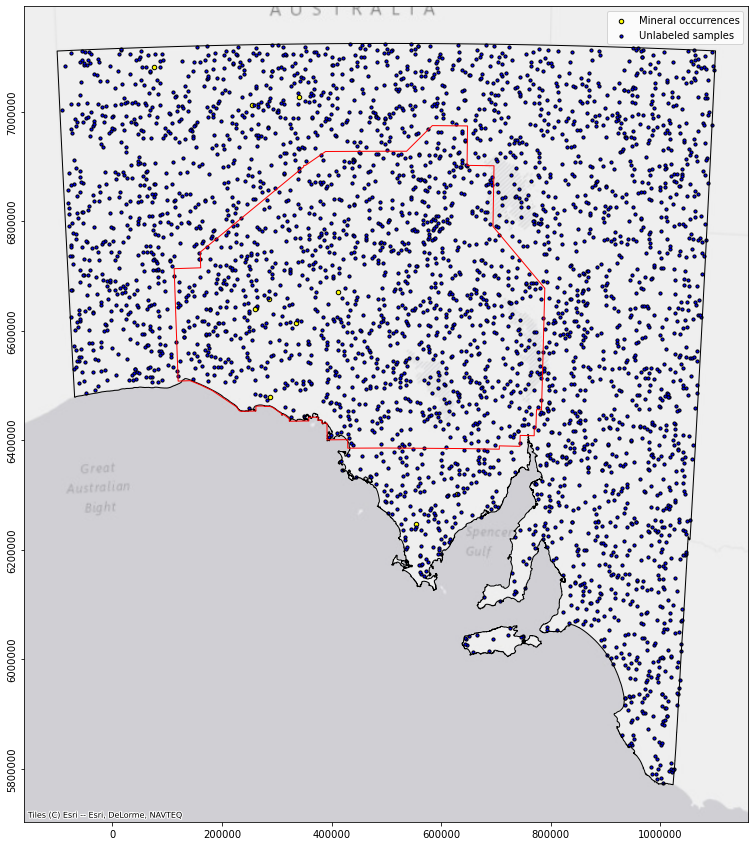

In [11]:
# generate and extract the coordinates of a number of random samples within the desired polygon
def get_non_deposits(polygon, num_features):
    bounds = polygon.bounds
    
    rand_x = np.random.uniform(low=bounds.loc[1]['minx'], high=bounds.loc[1]['maxx'], size=num_features*10)
    rand_y = np.random.uniform(low=bounds.loc[1]['miny'], high=bounds.loc[1]['maxy'], size=num_features*10)
    
    non_deposit_x = []
    non_deposit_y = []

    for x, y in zip(rand_x, rand_y):
        if len(non_deposit_x) == num_features*5:
            break
        p = Point((x, y))
        if p.within(polygon.geometry[1]) or p.within(polygon.geometry[0]):
            non_deposit_x.append(x)
            non_deposit_y.append(y)
    
    return non_deposit_x, non_deposit_y

# export the coordinates of the random samples to a CSV file
coords_file = './training_data_non_deposit_coords.csv'

if os.path.isfile(coords_file):
    print('The coordinates of unlabelled samples already exist.')
    non_deposit_coords = pd.read_csv(coords_file, index_col=False)
    non_deposit_x = pd.Series.tolist(non_deposit_coords['X'])
    non_deposit_y = pd.Series.tolist(non_deposit_coords['Y'])
else:
    non_deposit_x, non_deposit_y = get_non_deposits(sa_boundary, num_features)
    non_deposit_coords = pd.DataFrame(non_deposit_x, columns=['X'])
    non_deposit_coords['Y'] = non_deposit_y
    non_deposit_label = [0]*len(non_deposit_x)
    non_deposit_coords['label'] = non_deposit_label
    non_deposit_coords.to_csv(coords_file, index=False)
    print(f'The coordinates of unlabelled samples have been saved to {coords_file}.')

# plot random samples
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(deposit_x, deposit_y, color='yellow',  edgecolors='black', s=20)
ax.scatter(non_deposit_x, non_deposit_y, color='blue', edgecolors='black', s=10)
sa_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
gc_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.legend([
    'Mineral occurrences',
    'Unlabeled samples'
])
plt.show()

### Generating features using the coordinates of unlabelled samples

In [12]:
vector_file = './training_data_non_deposit_vector.csv'

if os.path.isfile(vector_file):
    print('The vector dataset (unlabelled samples) already exists.')
    non_deposit_vector_data = pd.read_csv(vector_file, index_col=False)
else:
    non_deposit_vector_data = get_vector_data(non_deposit_x, non_deposit_y)
    non_deposit_vector_data = non_deposit_vector_data[non_deposit_vector_data.columns.intersection(deposit_vector_data.columns)]
    non_deposit_vector_data.to_csv(vector_file, index=False)
    print(f'The vector dataset (unlabelled samples) has been saved to {vector_file}.')

categorical_file = './training_data_non_deposit_categorical.csv'

if os.path.isfile(categorical_file):
    print('The categorical dataset (unlabelled samples) already exists.')
    non_deposit_categorical_data = pd.read_csv(categorical_file, index_col=False)
else:
    non_deposit_categorical_data = get_categorical_data(non_deposit_x, non_deposit_y)
    non_deposit_categorical_data = non_deposit_categorical_data[non_deposit_categorical_data.columns.intersection(deposit_categorical_data.columns)]
    non_deposit_categorical_data.to_csv(categorical_file, index=False)
    print(f'The categorical dataset (unlabelled samples) has been saved to {categorical_file}.')

grid_file = './training_data_non_deposit_grids.csv'

if os.path.isfile(grid_file):
    print('The grid dataset (unlabelled samples) already exists.')
    non_deposit_grid_data = pd.read_csv(grid_file, index_col=False)
else:
    non_deposit_grid_data = get_grid_data(non_deposit_x, non_deposit_y, grid_filenames)
    non_deposit_grid_data = non_deposit_grid_data[non_deposit_grid_data.columns.intersection(deposit_grid_data.columns)]
    non_deposit_grid_data.to_csv(grid_file, index=False)
    print(f'The grid dataset (unlabelled samples) has been saved to {grid_file}.')

rs_file = './training_data_non_deposit_rs.csv'

if os.path.isfile(rs_file):
    print('The remote sensing dataset (unlabelled samples) already exists.')
    non_deposit_rs_data = pd.read_csv(rs_file, index_col=False)
else:
    non_deposit_rs_data = get_grid_data(non_deposit_x, non_deposit_y, rs_filenames)
    non_deposit_rs_data = non_deposit_rs_data[non_deposit_rs_data.columns.intersection(deposit_rs_data.columns)]
    non_deposit_rs_data.to_csv(rs_file, index=False)
    print(f'The remote sensing dataset (unlabelled samples) has been saved to {rs_file}.')

dtb_file = './training_data_non_deposit_dtb.csv'

if os.path.isfile(dtb_file):
    print('The depth to basement dataset (unlabelled samples) already exists.')
    non_deposit_dtb_data = pd.read_csv(dtb_file, index_col=False)
else:
    non_deposit_dtb_data = get_gradient_data(non_deposit_x, non_deposit_y, dtb_filenames)
    non_deposit_dtb_data = non_deposit_dtb_data[non_deposit_dtb_data.columns.intersection(deposit_dtb_data.columns)]
    non_deposit_dtb_data.to_csv(dtb_file, index=False)
    print(f'The depth to basement dataset (unlabelled samples) has been saved to {dtb_file}.')

The vector dataset (unlabelled samples) already exists.
The categorical dataset (unlabelled samples) already exists.
The grid dataset (unlabelled samples) already exists.
The remote sensing dataset (unlabelled samples) already exists.
The depth to basement dataset (unlabelled samples) already exists.


In [13]:
# concatenate all the features generated in the previous cell
training_data_file = './training_data_non_deposit_nogeochem.csv'

if os.path.isfile(training_data_file):
    print('The training data file (unlabelled samples) already exists.')
    non_deposit_training_data = pd.read_csv(training_data_file, index_col=False)
else:
    non_deposit_training_data = pd.concat([non_deposit_coords, non_deposit_grid_data, non_deposit_rs_data,
                                           non_deposit_dtb_data, non_deposit_vector_data, non_deposit_categorical_data], axis=1)
    non_deposit_training_data.to_csv(training_data_file, index=False)
    print(f'The training data file (unlabelled samples) has been saved to {training_data_file}.')

# export the features and labels
features_labels_file = f'./{commodity}/features_labels_{commodity}_nogeochem.csv'

# remove missing values
non_deposit_training_data = non_deposit_training_data.dropna()
non_deposit_training_data = non_deposit_training_data[non_deposit_training_data.columns.intersection(deposit_training_data.columns)]

# separate numerical and categorical features
non_deposit_numerical_data = non_deposit_training_data[deposit_numerical_data.columns]
non_deposit_categorical_data = non_deposit_training_data[deposit_categorical_data.columns]
non_deposit_labels = non_deposit_training_data[non_deposit_training_data.columns[2]]

# drop highly correlated features
numerical_data_df = pd.concat([deposit_numerical_data, non_deposit_numerical_data]).reset_index(drop=True)
# create a correlation matrix
corr_matrix = numerical_data_df.corr(method='spearman').abs()
# select the upper triangle of the correlation matrix
corr_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# find features with the correlation greater than 0.7
corr_drop = [column for column in corr_upper.columns if any(corr_upper[column] > 0.7)]
# drop features
numerical_data_df.drop(corr_drop, axis=1, inplace=True)
numerical_data_columns = numerical_data_df.columns.tolist()

# concatenate the features generated using mineral occurrences and random samples
deposit_training_data_uncorr = pd.concat([deposit_coords, deposit_numerical_data[deposit_numerical_data.columns.intersection(numerical_data_df.columns)],
                                          deposit_categorical_data], axis=1).reset_index(drop=True)

numerical_data = numerical_data_df.to_numpy()
categorical_data = np.vstack((deposit_categorical_data, non_deposit_categorical_data)).astype('str')

scaler = StandardScaler()
scaler.fit(numerical_data)
numerical_features = scaler.transform(numerical_data)

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(categorical_data)
categorical_features = enc.transform(categorical_data).toarray()

features = np.hstack((numerical_features, categorical_features))
labels = pd.concat([deposit_labels, non_deposit_labels]).reset_index(drop=True)
features_labels = np.hstack((features, np.reshape(labels.to_numpy(), (-1, 1))))
categorical_data_columns = enc.get_feature_names(deposit_categorical_data.columns).tolist()
features_list = numerical_data_columns + categorical_data_columns
features_list_label = features_list.copy()
features_list_label.append('label')
features_labels = pd.DataFrame(features_labels, columns=features_list_label)
features_labels.to_csv(features_labels_file, index=False)
print(f'The features and labels file has been saved to {features_labels_file}.')

The training data file (unlabelled samples) already exists.
The features and labels file has been saved to ./Cr/features_labels_Cr_nogeochem.csv.


### Standard Random Forest classification
Please note that prior to running the next cell, you need to generate a synthetic set of positive samples using the SMOTE-GAN notebook.

In [14]:
# generate a confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    '''pretty print for confusion matrixes'''
    columnwidth = max([len(x) for x in labels]) + 4
    empty_cell = ' ' * columnwidth
    print('    ' + empty_cell, end=' ')
    for label in labels:
        print('%{0}s'.format(columnwidth) % 'pred_' + label, end=' ')
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print('    %{0}s'.format(columnwidth) % 'true_' + label1, end=' ')
        for j in range(len(labels)):
            cell = '%{0}.1f'.format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            if cell:
                print(cell, end=' ')
        print()

features_labels_file = f'./{commodity}/smote_gan_{commodity}_nogeochem.csv'
features_labels = pd.read_csv(features_labels_file, index_col=False)
features_labels_pul = features_labels.sample(frac=1).reset_index(drop=True)
features_pul = features_labels_pul[features_labels_pul.columns[:-1]].copy()
labels_pul = features_labels_pul[features_labels_pul.columns[-1]].copy()

# hide 30 percent of the samples labelled one
hidden_size = round(0.3 * (labels_pul==1).sum())

labels_pul_training = labels_pul.copy()
rand_ind = np.random.choice(labels_pul_training[labels_pul_training==1].index, replace=False, size=hidden_size)
labels_pul_training.loc[rand_ind] = 0

# Random Forest model structure
rf = RandomForestClassifier(n_jobs=-1, random_state=1)

print('Parameters currently in use:\n')
pprint(rf.get_params())

# n_estimators: number of trees in the foreset
# max_features: max number of features considered for splitting a node
# max_depth: max number of levels in each decision tree
# min_samples_split: min number of data points placed in a node before the node is split
# min_samples_leaf: min number of data points allowed in a leaf node
# bootstrap: method for sampling data points (with or without replacement)

rf.fit(features_pul, labels_pul_training)

print('')
print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf.predict(features_pul)))

print('')
print('---- {} ----'.format('Standard Random Forest (Hidden Samples)'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))
print('Recall: ', recall_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))
print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))
print('F1 score: ', f1_score(labels_pul.loc[rand_ind], rf.predict(features_pul.loc[rand_ind])))

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative       3098.0          0.0 
           true_positive        593.0       2505.0 
None

Precision:  1.0
Recall:  0.8085861846352486
Accuracy:  0.9042930923176242
F1 score:  0.8941638407995717
ROC AUC score:  0.9042930923176242

---- Standard Random Forest (Hidden Samples) ----
                        pred_negative        pred_positive 
           true_negative          0.0          0.0 
           true_positive        593.0        336.0 
None

P

### Hyperparameter tuning

In [15]:
# number of trees in the Random Forest
n_estimators = [int(x) for x in np.arange(20, 220, 20)]
# number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# maximum number of levels in each tree
max_depth = [int(x) for x in np.arange(10, 110, 10)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]
# create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]}


In [16]:
# use the random grid to search for best hyperparameters
# random search of hyperparameters using 10 fold cross validation
# search across 100 different combinations and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
                               cv=10, verbose=2, random_state=1, n_jobs=-1)

# fit the random search model
rf_random.fit(features_pul, labels_pul_training)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140, 160, 180,
                                                         200]},
                   random_state=1, verbose=2)

In [17]:
# best set of hyperparameters
rf_random.best_params_

{'n_estimators': 120,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [18]:
# run the Random Forest classifier using the best set of hyperparameters
rf_random_best = rf_random.best_estimator_
rf_random_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf_random_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf_random_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf_random_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf_random_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf_random_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf_random_best.predict(features_pul)))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative       3098.0          0.0 
           true_positive         91.0       3007.0 
None

Precision:  1.0
Recall:  0.9706262104583603
Accuracy:  0.9853131052291801
F1 score:  0.9850941850941851
ROC AUC score:  0.9853131052291801


In [19]:
# create the parameter grid based on the results of the random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 5, 10],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [30, 40, 50, 110, 120, 130]
}

# instantiate the grid search model
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

# fit the grid search
rf_grid.fit(features_pul, labels_pul_training)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [2, 5, 10],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [30, 40, 50, 110, 120, 130]},
             verbose=2)

In [20]:
# best set of hyperparameters
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 120}

In [21]:
# run the Random Forest classifier using the best set of hyperparameters
rf_grid_best = rf_grid.best_estimator_
rf_grid_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf_grid_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf_grid_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf_grid_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf_grid_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf_grid_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf_grid_best.predict(features_pul)))

print('')
print('---- {} ----'.format('Standard Random Forest (Hidden Samples)'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))
print('Recall: ', recall_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))
print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))
print('F1 score: ', f1_score(labels_pul.loc[rand_ind], rf_grid_best.predict(features_pul.loc[rand_ind])))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative       3098.0          0.0 
           true_positive         91.0       3007.0 
None

Precision:  1.0
Recall:  0.9706262104583603
Accuracy:  0.9853131052291801
F1 score:  0.9850941850941851
ROC AUC score:  0.9853131052291801

---- Standard Random Forest (Hidden Samples) ----
                        pred_negative        pred_positive 
           true_negative          0.0          0.0 
           true_positive         84.0        845.0 
None

Precision:  1.0
Recall:  0.9095801937567277
Accuracy:  0.9095801937567277
F1 score:  0.9526493799323563


In [22]:
bc = BaggingPuClassifier(rf_grid_best, max_samples=int(sum(labels_pul_training)), n_jobs=-1, random_state=1)
bc.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Bagging PU'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, bc.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, bc.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, bc.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, bc.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, bc.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, bc.predict(features_pul)))

print('')
print('---- {} ----'.format('Bagging PU (Hidden Samples)'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))
print('Recall: ', recall_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))
print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))
print('F1 score: ', f1_score(labels_pul.loc[rand_ind], bc.predict(features_pul.loc[rand_ind])))

---- Bagging PU ----
                        pred_negative        pred_positive 
           true_negative       3098.0          0.0 
           true_positive         21.0       3077.0 
None

Precision:  1.0
Recall:  0.9932214331826985
Accuracy:  0.9966107165913493
F1 score:  0.9965991902834008
ROC AUC score:  0.9966107165913493

---- Bagging PU (Hidden Samples) ----
                        pred_negative        pred_positive 
           true_negative          0.0          0.0 
           true_positive         17.0        912.0 
None

Precision:  1.0
Recall:  0.9817007534983854
Accuracy:  0.9817007534983854
F1 score:  0.9907658881042911


In [ ]:
# number of trees in the Random Forest
n_estimators = [int(x) for x in np.arange(10, 110, 10)]
# number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# maximum number of levels in each tree
max_depth = [int(x) for x in np.arange(10, 60, 10)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]
# create the random grid
bc_random_grid = {'base_estimator__n_estimators': n_estimators,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               'base_estimator__bootstrap': bootstrap}
pprint(bc_random_grid)

In [ ]:
bc_random = RandomizedSearchCV(estimator=bc, param_distributions=bc_random_grid, n_iter=100,
                               cv=10, verbose=2, random_state=1, n_jobs=-1)
bc_random.fit(features_pul, labels_pul_training)

In [ ]:
# best set of hyperparameters
bc_random.best_params_

In [ ]:
# run the Random Forest classifier using the best set of hyperparameters
bc_random_best = bc_random.best_estimator_
bc_random_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Bagging PU'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, bc_random_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, bc_random_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, bc_random_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, bc_random_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, bc_random_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, bc_random_best.predict(features_pul)))

In [ ]:
# create the parameter grid based on the results of the random search
bc_param_grid = {
    'base_estimator__bootstrap': [True],
    'base_estimator__max_depth': [2, 5, 10],
    'base_estimator__max_features': ['auto'],
    'base_estimator__min_samples_leaf': [1, 2, 4],
    'base_estimator__min_samples_split': [2],
    'base_estimator__n_estimators': [30, 40, 50]
}

# instantiate the grid search model
bc_grid = GridSearchCV(estimator=bc, param_grid=bc_param_grid, cv=10, n_jobs=-1, verbose=2)

# fit the grid search
bc_grid.fit(features_pul, labels_pul_training)

In [ ]:
# best set of hyperparameters
bc_grid.best_params_

In [ ]:
# run the Random Forest classifier using the best set of hyperparameters
bc_grid_best = bc_grid.best_estimator_
bc_grid_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, bc_grid_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, bc_grid_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, bc_grid_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, bc_grid_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, bc_grid_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, bc_grid_best.predict(features_pul)))

print('')
print('---- {} ----'.format('Standard Random Forest (Hidden Samples)'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul.loc[rand_ind], bc_grid_best.predict(features_pul.loc[rand_ind])), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul.loc[rand_ind], bc_grid_best.predict(features_pul.loc[rand_ind])))
print('Recall: ', recall_score(labels_pul.loc[rand_ind], bc_grid_best.predict(features_pul.loc[rand_ind])))
print('Accuracy: ', accuracy_score(labels_pul.loc[rand_ind], bc_grid_best.predict(features_pul.loc[rand_ind])))
print('F1 score: ', f1_score(labels_pul.loc[rand_ind], bc_grid_best.predict(features_pul.loc[rand_ind])))

### Feature importance

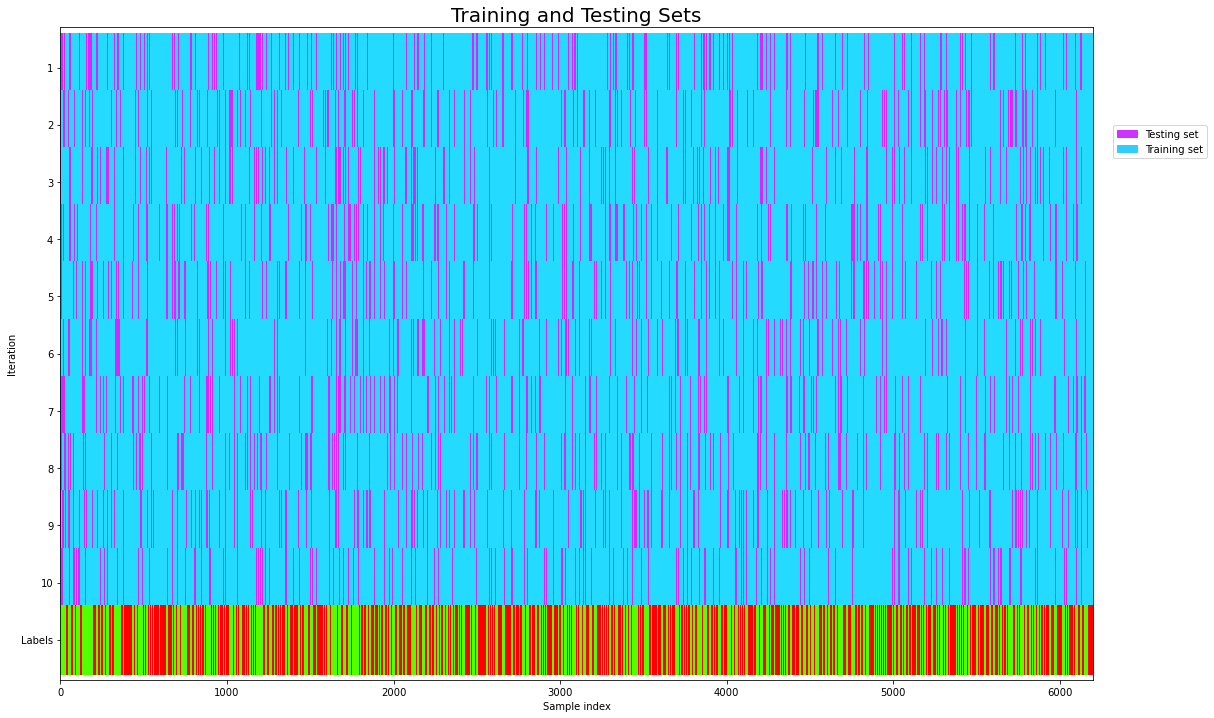

In [23]:
# generate different sets of training samples
iter_num = 10
labels_pul_training_all = np.empty((features_labels_pul.shape[0], iter_num))

fig, ax = plt.subplots()

for i in range(iter_num):
    # hide positive samples
    labels_pul_training = labels_pul.copy()
    labels_pul_training.loc[
        np.random.choice(
            labels_pul_training[labels_pul_training==1].index,
            replace=False,
            size=hidden_size
            )
        ] = 0
    
    labels_pul_training_all[:, i] = labels_pul_training
        
    # fill in indices with the training/testing groups
    indices = labels_pul - labels_pul_training

    # visualise the results
    ax.scatter(range(len(indices)), [i+.5]*len(indices),
                   c=indices, marker='_', lw=70, cmap='cool',
                   vmin=-.2, vmax=1.2)

# plot the data classes and groups at the end
ax.scatter(range(len(features_labels_pul)), [i+1.5]*len(features_labels_pul), c=labels_pul, marker='_', lw=70, cmap='prism')

n_splits = iter_num
yticklabels = list(range(1, n_splits+1)) + ['Labels']
ax.set(yticks=np.arange(n_splits+1)+0.5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel='Iteration',
           ylim=[n_splits+1.2, -.2], xlim=[0, len(features_labels_pul)])
ax.set_title('Training and Testing Sets', fontsize=20)
ax.legend([Patch(color=plt.cm.cool(.8)), Patch(color=plt.cm.cool(.2))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
fig.set_size_inches(18.5, 12)

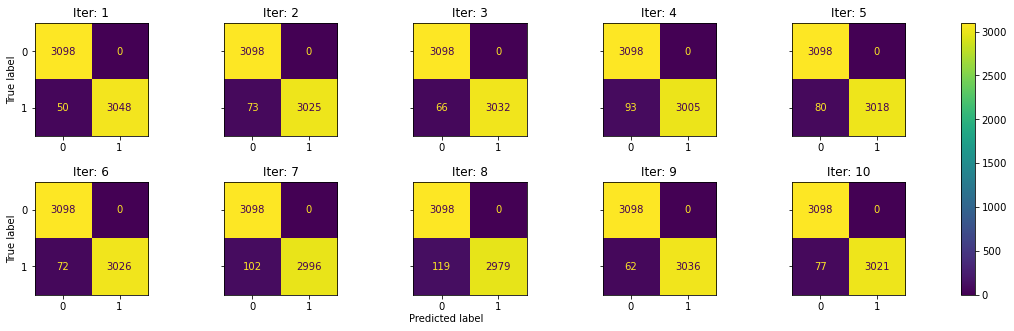

In [24]:
# confusion matrices for different sets of training and testing samples
f, axes = plt.subplots(2, 5, figsize=(20, 5), sharey='row')

j = 0
k = 0

for i in range(iter_num):
    rf_grid_best.fit(features_pul, labels_pul_training_all[:, i])
    pred = rf_grid_best.predict(features_pul)
    
    cf_matrix = confusion_matrix(labels_pul, pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[j, k])
    disp.ax_.set_title('Iter: '+str(i+1))
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0 and i!=5:
        disp.ax_.set_ylabel('')
    
    k += 1
    if i == 4:
        j = 1
        k = 0

f.text(0.4, 0.05, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [25]:
# run the Random Forest classifier for ten times and take the average of feature importance values
importances = np.empty((len(features_list), iter_num))

for i in tqdm(range(iter_num)):
    rf_grid_best.fit(features_pul, labels_pul_training_all[:, i])
    importances[:, i] = rf_grid_best.feature_importances_

importances_mean = importances.mean(axis=1)
importances_var = importances.var(axis=1)

feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(features_list, importances_mean)]
feature_importances = sorted(feature_importances, key=lambda x:x[1], reverse=True)
[print('Feature: {:60} Importance: {}'.format(*pair)) for pair in feature_importances]

with open(f'feature_importance_{commodity}.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(feature_importances)

  0%|          | 0/10 [00:00<?, ?it/s]

Feature: Res_C1                                                       Importance: 0.07353
Feature: Archaean - Early Mesoproterozoic polygons_Deformed gabbro to granite of the Kararan Orogeny and earlier transitional Kimban-Kararan events Importance: 0.0656
Feature: Ferric_oxide_content_grayscale_std                           Importance: 0.05964
Feature: SA_TMI_VRTP_CAUCHY_3rd_GDA94_std                             Importance: 0.05884
Feature: Ferrous_iron_index_grayscale_correlation                     Importance: 0.05045
Feature: SA_TMI_GDA94_correlation                                     Importance: 0.04735
Feature: SA_GRAV_1VD_ONSHORE_GDA94_mean                               Importance: 0.04562
Feature: Res_C4                                                       Importance: 0.03925
Feature: SA_RAD_U_dissimilarity                                       Importance: 0.02849
Feature: Cambrian to late Carboniferous geological provinces_Contact  Importance: 0.02412
Feature: Res_C7        

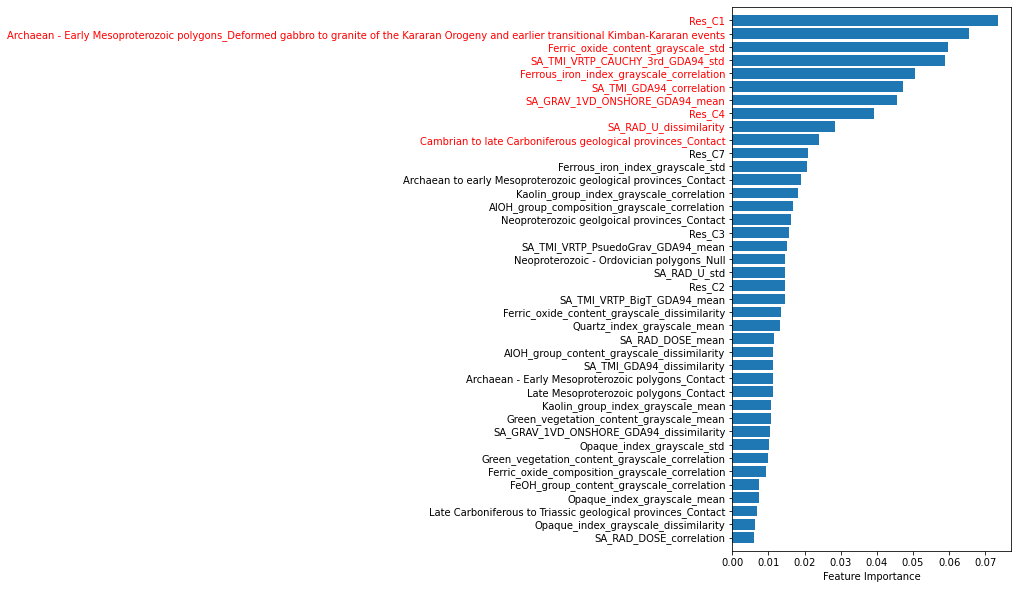

In [26]:
# print significant features above some threshold
feature_importances.sort(key=lambda x:x[1])
feature_importances_plot = feature_importances[-40:]

fig, ax = plt.subplots(figsize=(5, 10))

ft_imps = [x[1] for x in feature_importances_plot]
y_pos = np.arange(len(feature_importances_plot))
ax.barh(y_pos, ft_imps, align='center')
ax.set_ylim(-1, len(ft_imps))
ax.set_yticks(range(len(ft_imps)))
ax.set_yticklabels([x[0] for x in feature_importances_plot])

# highlight top 10 features
for i in range(len(ft_imps)-10, len(ft_imps)):
    ax.get_yticklabels()[i].set_color('red')

ax.set_xlabel('Feature Importance')

plt.show()

### Target points covering South Australia

The coordinates of samples already exist.
Number of samples:  2459


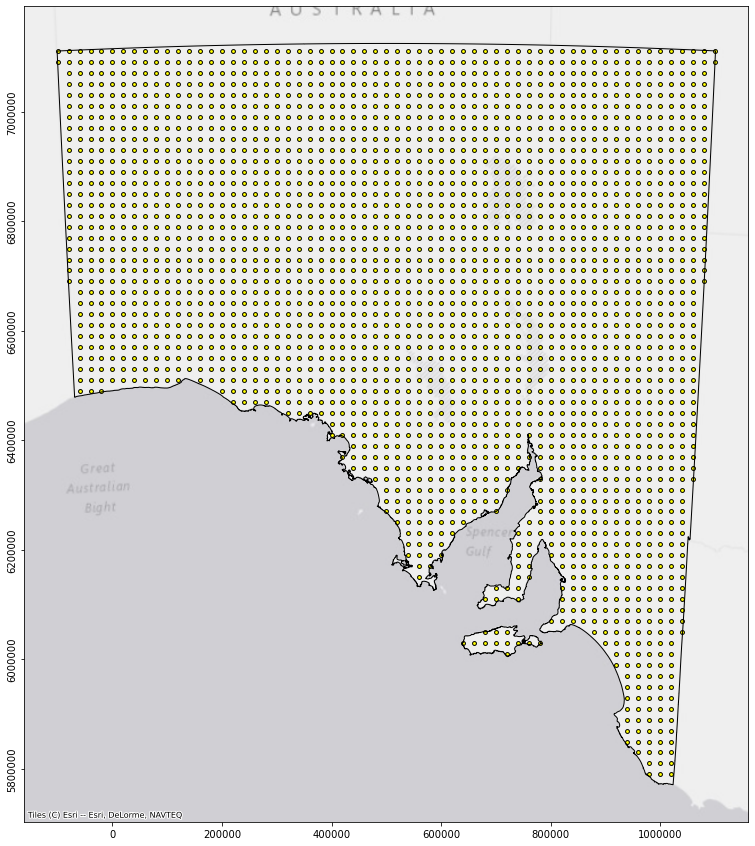

In [27]:
# set the sampling resolution
dist_x, dist_y = (20000, 20000)
extent = namedtuple('Extent', ['left', 'right', 'bottom', 'top'])
sample_frame = extent(**{'left':-120000, 'right':1120000, 'bottom':5750000, 'top':7150000}) # SA

x = np.arange(sample_frame.left, sample_frame.right, dist_x)
y = np.arange(sample_frame.bottom, sample_frame.top, dist_y)
nx = len(x)
ny = len(y)
xs, ys = np.meshgrid(x, y)

sample_coords_file = './sample_data_coords.csv'
sample_mask_file = './sample_mask.csv'

# export the coordinates of the samples and create a mask to keep the points only inside the target polygon boundaries
if os.path.isfile(sample_coords_file) and os.path.isfile(sample_mask_file):
    print('The coordinates of samples already exist.')
    sample_coords = pd.read_csv(sample_coords_file)
    sample_x = sample_coords['X']
    sample_y = sample_coords['Y']
    mask_coords = genfromtxt(sample_mask_file, delimiter=',')
    mask_x = mask_coords[:, 0]
    mask_y = mask_coords[:, 1]
    sample_mask = mask_coords[:, 2]
else:
    sample_x = []
    sample_y = []
    sample_mask = []
    for xx, yy in zip(xs.flatten(), ys.flatten()):
        p = Point((xx, yy))
        if p.within(sa_boundary.geometry[1]) or p.within(sa_boundary.geometry[0]):
            sample_x.append(xx)
            sample_y.append(yy)
            sample_mask.append(True)
        else:
            sample_mask.append(False)
    
    sample_coords = pd.DataFrame(sample_x, columns=['X'])
    sample_coords['Y'] = sample_y
    sample_coords.to_csv(sample_coords_file, index=False)
    
    mask_x = np.array([xs.flatten()]).T
    mask_y = np.array([ys.flatten()]).T
    sample_mask = np.array([sample_mask]).T
    mask_coords = np.hstack((mask_x, mask_y, sample_mask))
    np.savetxt(sample_mask_file, mask_coords, delimiter=',')
    print('The coordinates of samples and mask have been saved.')

print(f'Number of samples: ', len(sample_x))

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(sample_x, sample_y, color='yellow',  edgecolors='black', s=15)
sa_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.show()

### Generating features using the coordinates of target points

In [28]:
vector_file = './sample_data_vector.csv'

if os.path.isfile(vector_file):
    print('The vector dataset (samples) already exists.')
    sample_vector_data = pd.read_csv(vector_file, index_col=False)
else:
    sample_vector_data = get_vector_data(sample_x, sample_y)
    sample_vector_data = sample_vector_data[sample_vector_data.columns.intersection(deposit_vector_data.columns)]
    sample_vector_data.to_csv(vector_file, index=False)
    print(f'The vector dataset (samples) has been saved to {vector_file}.')

categorical_file = './sample_data_categorical.csv'

if os.path.isfile(categorical_file):
    print('The categorical dataset (samples) already exists.')
    sample_categorical_data = pd.read_csv(categorical_file, index_col=False)
else:
    sample_categorical_data = get_categorical_data(sample_x, sample_y)
    sample_categorical_data = sample_categorical_data[sample_categorical_data.columns.intersection(deposit_categorical_data.columns)]
    sample_categorical_data.to_csv(categorical_file, index=False)
    print(f'The categorical dataset (samples) has been saved to {categorical_file}.')

grid_file = './sample_data_grids.csv'

if os.path.isfile(grid_file):
    print('The grid dataset (samples) already exists.')
    sample_grid_data = pd.read_csv(grid_file, index_col=False)
else:
    sample_grid_data = get_grid_data(sample_x, sample_y, grid_filenames)

    sample_grid_data = sample_grid_data[sample_grid_data.columns.intersection(deposit_grid_data.columns)]
    sample_grid_data.to_csv(grid_file, index=False)
    print(f'The grid dataset (samples) has been saved to {grid_file}.')

rs_file = './sample_data_rs.csv'

if os.path.isfile(rs_file):
    print('The remote sensing dataset (samples) already exists.')
    sample_rs_data = pd.read_csv(rs_file, index_col=False)
else:
    sample_rs_data = get_grid_data(sample_x, sample_y, rs_filenames)

    sample_rs_data = sample_rs_data[sample_rs_data.columns.intersection(deposit_rs_data.columns)]
    sample_rs_data.to_csv(rs_file, index=False)
    print(f'The remote sensing dataset (samples) has been saved to {rs_file}.')
    
dtb_file = './sample_data_dtb.csv'

if os.path.isfile(dtb_file):
    print('The depth to basement dataset (samples) already exists.')
    sample_dtb_data = pd.read_csv(dtb_file, index_col=False)
else:
    sample_dtb_data = get_gradient_data(sample_x, sample_y, dtb_filenames)

    sample_dtb_data = sample_dtb_data[sample_dtb_data.columns.intersection(deposit_dtb_data.columns)]
    sample_dtb_data.to_csv(dtb_file, index=False)
    print(f'The depth to basement dataset (samples) has been saved to {dtb_file}.')

The vector dataset (samples) already exists.
The categorical dataset (samples) already exists.
The grid dataset (samples) already exists.
The remote sensing dataset (samples) already exists.
The depth to basement dataset (samples) already exists.


In [29]:
# concatenate all the features generated in the previous cell
sample_data_file = './sample_data_nogeochem.csv'

if os.path.isfile(sample_data_file):
    print('The sample data file already exists.')
    sample_data = pd.read_csv(sample_data_file, index_col=False)
else:
    sample_data = pd.concat([sample_coords, sample_grid_data, sample_rs_data, sample_dtb_data,
                             sample_vector_data, sample_categorical_data], axis=1)
    sample_data.to_csv(sample_data_file, index=False)
    print(f'The sample data file has been saved to {sample_data_file}.')

index_null = sample_data[sample_data.isnull().any(axis=1)].index.to_list()

for index in index_null:
    for i in range(mask_coords.shape[0]):
        if sample_data['X'][index] == mask_coords[i, 0] and sample_data['Y'][index] == mask_coords[i, 1]:
            sample_mask[i] = False

# remove missing values
sample_data = sample_data.dropna()
sample_data = sample_data[sample_data.columns.intersection(deposit_training_data_uncorr.columns)]

# separate numerical and categorical features
sample_numerical_data = sample_data[sample_data.columns[2:sample_data.shape[1]-sample_categorical_data.shape[1]]]
sample_categorical_data = sample_data[sample_data.columns[sample_data.shape[1]-sample_categorical_data.shape[1]:sample_data.shape[1]]]

scaler = StandardScaler()
scaler.fit(sample_numerical_data)
sample_numerical_features = scaler.transform(sample_numerical_data)

sample_categorical_features = enc.transform(sample_categorical_data.astype('str')).toarray()

sample_features = np.hstack((sample_numerical_features, sample_categorical_features))
np.savetxt('./sample_features_nogeochem.csv', sample_features, delimiter=',')

The sample data file already exists.


### Target points covering the Gawler Craton

The coordinates of samples already exist.
Number of samples:  11766


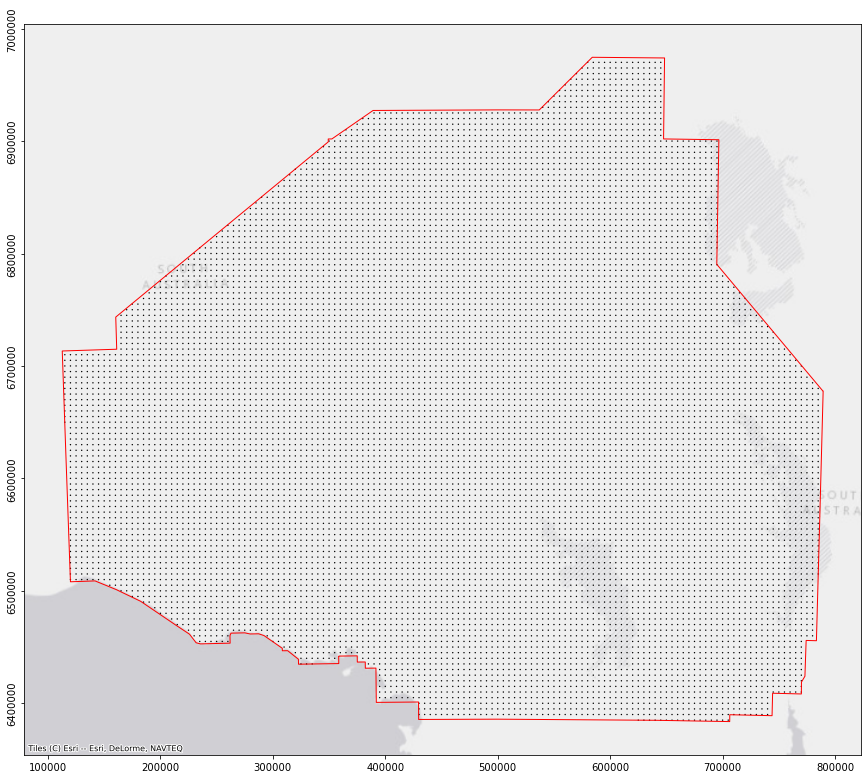

In [30]:
# set the sampling resolution
dist_x_gc, dist_y_gc = (5000, 5000)
extent = namedtuple('Extent', ['left', 'right', 'bottom', 'top'])
sample_frame_gc = extent(**{'left':105000, 'right':798000, 'bottom':6375000, 'top':6980000}) # Gawler Craton

x_gc = np.arange(sample_frame_gc.left, sample_frame_gc.right, dist_x_gc)
y_gc = np.arange(sample_frame_gc.bottom, sample_frame_gc.top, dist_y_gc)
nx_gc = len(x_gc)
ny_gc = len(y_gc)
xs, ys = np.meshgrid(x_gc, y_gc)

sample_coords_file = './sample_data_gc_coords.csv'
sample_mask_file = './sample_mask_gc.csv'

# export the coordinates of the samples and create a mask to keep the points only inside the target polygon boundaries
if os.path.isfile(sample_coords_file) and os.path.isfile(sample_mask_file):
    print('The coordinates of samples already exist.')
    sample_coords_gc = pd.read_csv(sample_coords_file)
    sample_x_gc = sample_coords_gc['X']
    sample_y_gc = sample_coords_gc['Y']
    mask_coords_gc = genfromtxt(sample_mask_file, delimiter=',')
    mask_x_gc = mask_coords_gc[:, 0]
    mask_y_gc = mask_coords_gc[:, 1]
    sample_mask_gc = mask_coords_gc[:, 2]
else:
    sample_x_gc = []
    sample_y_gc = []
    sample_mask_gc = []
    for xx, yy in zip(xs.flatten(), ys.flatten()):
        p = Point((xx, yy))
        if p.within(gc_boundary.geometry[0]):
            sample_x_gc.append(xx)
            sample_y_gc.append(yy)
            sample_mask_gc.append(True)
        else:
            sample_mask_gc.append(False)
    
    sample_coords_gc = pd.DataFrame(sample_x_gc, columns=['X'])
    sample_coords_gc['Y'] = sample_y_gc
    sample_coords_gc.to_csv(sample_coords_file, index=False)
    
    mask_x_gc = np.array([xs.flatten()]).T
    mask_y_gc = np.array([ys.flatten()]).T
    sample_mask_gc = np.array([sample_mask_gc]).T
    mask_coords_gc = np.hstack((mask_x_gc, mask_y_gc, sample_mask_gc))
    np.savetxt(sample_mask_file, mask_coords_gc, delimiter=',')
    print('The coordinates of samples and mask have been saved.')

print(f'Number of samples: ', len(sample_x_gc))

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(sample_x_gc, sample_y_gc, color='black',  edgecolors='none', s=2)
gc_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.show()

### Generating features using the coordinates of target points

In [31]:
vector_file = './sample_data_gc_vector.csv'

if os.path.isfile(vector_file):
    print('The vector dataset (samples) already exists.')
    sample_vector_data = pd.read_csv(vector_file, index_col=False)
else:
    sample_vector_data = get_vector_data(sample_x_gc, sample_y_gc)
    sample_vector_data = sample_vector_data[sample_vector_data.columns.intersection(deposit_vector_data.columns)]
    sample_vector_data.to_csv(vector_file, index=False)
    print(f'The vector dataset (samples) has been saved to {vector_file}.')

categorical_file = './sample_data_gc_categorical.csv'

if os.path.isfile(categorical_file):
    print('The categorical dataset (samples) already exists.')
    sample_categorical_data = pd.read_csv(categorical_file, index_col=False)
else:
    sample_categorical_data = get_categorical_data(sample_x_gc, sample_y_gc)
    sample_categorical_data = sample_categorical_data[sample_categorical_data.columns.intersection(deposit_categorical_data.columns)]
    sample_categorical_data.to_csv(categorical_file, index=False)
    print(f'The categorical dataset (samples) has been saved to {categorical_file}.')

grid_file = './sample_data_gc_grids.csv'

if os.path.isfile(grid_file):
    print('The grid dataset (samples) already exists.')
    sample_grid_data = pd.read_csv(grid_file, index_col=False)
else:
    sample_grid_data = get_grid_data(sample_x_gc, sample_y_gc, grid_filenames)

    sample_grid_data = sample_grid_data[sample_grid_data.columns.intersection(deposit_grid_data.columns)]
    sample_grid_data.to_csv(grid_file, index=False)
    print(f'The grid dataset (samples) has been saved to {grid_file}.')

rs_file = './sample_data_gc_rs.csv'

if os.path.isfile(rs_file):
    print('The remote sensing dataset (samples) already exists.')
    sample_rs_data = pd.read_csv(rs_file, index_col=False)
else:
    sample_rs_data = get_grid_data(sample_x_gc, sample_y_gc, rs_filenames)

    sample_rs_data = sample_rs_data[sample_rs_data.columns.intersection(deposit_rs_data.columns)]
    sample_rs_data.to_csv(rs_file, index=False)
    print(f'The remote sensing dataset (samples) has been saved to {rs_file}.')
    
dtb_file = './sample_data_gc_dtb.csv'

if os.path.isfile(dtb_file):
    print('The depth to basement dataset (samples) already exists.')
    sample_dtb_data = pd.read_csv(dtb_file, index_col=False)
else:
    sample_dtb_data = get_gradient_data(sample_x_gc, sample_y_gc, dtb_filenames)

    sample_dtb_data = sample_dtb_data[sample_dtb_data.columns.intersection(deposit_dtb_data.columns)]
    sample_dtb_data.to_csv(dtb_file, index=False)
    print(f'The depth to basement dataset (samples) has been saved to {dtb_file}.')

The vector dataset (samples) already exists.
The categorical dataset (samples) already exists.
The grid dataset (samples) already exists.
The remote sensing dataset (samples) already exists.
The depth to basement dataset (samples) already exists.


In [32]:
# concatenate all the features generated in the previous cell
sample_data_file = './sample_data_gc_nogeochem.csv'

if os.path.isfile(sample_data_file):
    print('The sample data file already exists.')
    sample_data_gc = pd.read_csv(sample_data_file, index_col=False)
else:
    sample_data_gc = pd.concat([sample_coords_gc, sample_grid_data, sample_rs_data, sample_dtb_data,
                                sample_vector_data, sample_categorical_data], axis=1)
    sample_data_gc.to_csv(sample_data_file, index=False)
    print(f'The sample data file has been saved to {sample_data_file}.')

index_null = sample_data_gc[sample_data_gc.isnull().any(axis=1)].index.to_list()

for index in index_null:
    for i in range(mask_coords_gc.shape[0]):
        if sample_data_gc['X'][index] == mask_coords_gc[i, 0] and sample_data_gc['Y'][index] == mask_coords_gc[i, 1]:
            sample_mask_gc[i] = False

# remove missing values
sample_data_gc = sample_data_gc.dropna()
sample_data_gc = sample_data_gc[sample_data_gc.columns.intersection(deposit_training_data_uncorr.columns)]

# separate numerical and categorical features
sample_numerical_data = sample_data_gc[sample_data_gc.columns[2:sample_data_gc.shape[1]-sample_categorical_data.shape[1]]]
sample_categorical_data = sample_data_gc[sample_data_gc.columns[sample_data_gc.shape[1]-sample_categorical_data.shape[1]:sample_data_gc.shape[1]]]

scaler = StandardScaler()
scaler.fit(sample_numerical_data)
sample_numerical_features = scaler.transform(sample_numerical_data)

sample_categorical_features = enc.transform(sample_categorical_data.astype('str')).toarray()

sample_features_gc = np.hstack((sample_numerical_features, sample_categorical_features))
np.savetxt('./sample_features_gc_nogeochem.csv', sample_features_gc, delimiter=',')

The sample data file already exists.


### Prospectivity maps
#### Average probability

In [33]:
# run the model for ten times using different sets of training samples and take the average of probability values for each target point
probs = np.empty((sample_features.shape[0], iter_num))
probs_gc = np.empty((sample_features_gc.shape[0], iter_num))

for i in tqdm(range(iter_num)):
    bc.fit(features_pul, labels_pul_training_all[:, i])
    
    probs[:, i] = bc.predict_proba(sample_features)[:, 1]
    probs_gc[:, i] = bc.predict_proba(sample_features_gc)[:, 1]

# comment this section and uncomment the next one if interested to see original probability scores
# --------------------
scaler = MinMaxScaler()
point_probs = scaler.fit_transform(probs)
point_probs_mean = point_probs.mean(axis=1)
point_probs_var = point_probs.var(axis=1)

point_probs_gc = scaler.fit_transform(probs_gc)
point_probs_gc_mean = point_probs_gc.mean(axis=1)
point_probs_var_gc = point_probs_gc.var(axis=1)

# --------------------
# point_probs_mean = probs.mean(axis=1)
# point_probs_var = probs.var(axis=1)

# point_probs_gc_mean = probs_gc.mean(axis=1)
# point_probs_var_gc = probs_gc.var(axis=1)

  0%|          | 0/10 [00:00<?, ?it/s]

#### South Australia
##### Probability

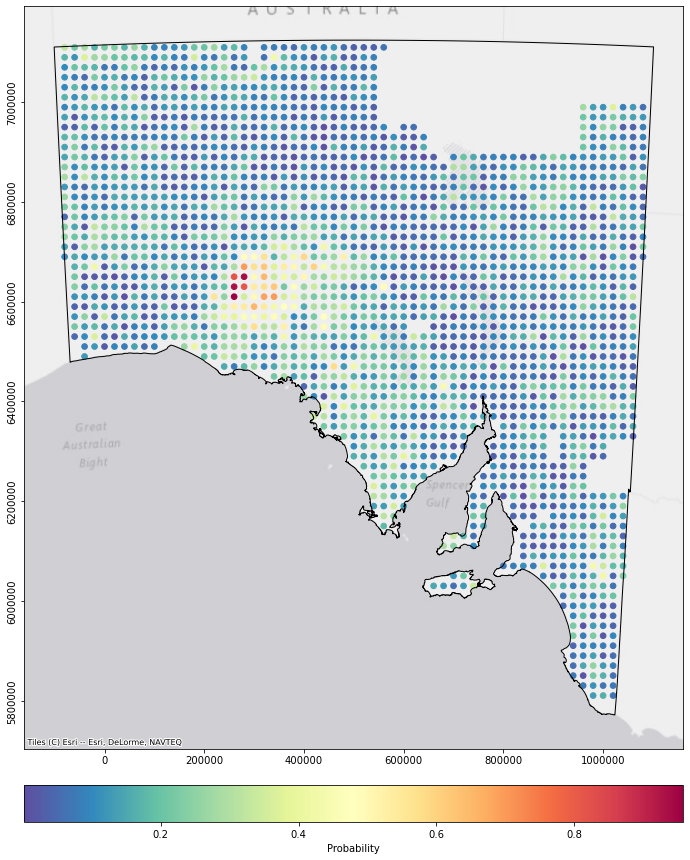

In [34]:
plot_x = sample_data['X']
plot_y = sample_data['Y']

# plot the probability map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(plot_x, plot_y, 32., c=point_probs_mean, cmap='Spectral_r')

sa_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))

# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
plt.show()

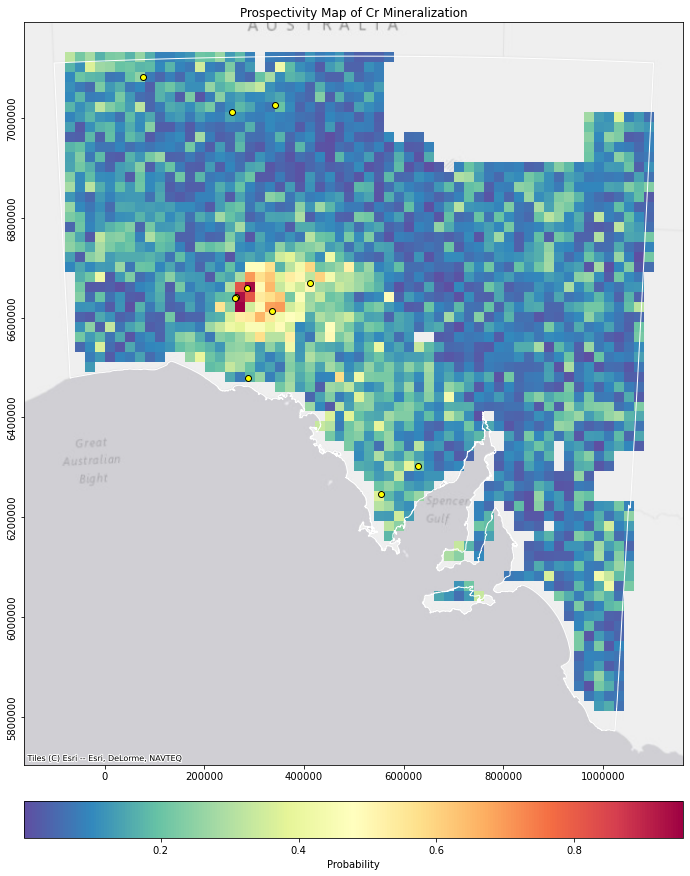

In [35]:
# create a probability map using the target points
probabilities = []
count = 0

for mask in sample_mask:
    if mask:
        probabilities.append(point_probs_mean[count])
        count += 1
    else:
        probabilities.append(np.nan)

probabilities_2d = np.reshape(probabilities, (ny, nx))
probabilities_2d_ud = np.flipud(np.reshape(probabilities, (ny, nx)))

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(deposit_x, deposit_y, color='yellow', edgecolors='black')
sa_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.imshow(probabilities_2d, cmap='Spectral_r', origin='lower', interpolation='none',
           extent=(sample_frame.left, sample_frame.right, sample_frame.bottom, sample_frame.top))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Prospectivity Map of {commodity} Mineralisation')
plt.show()

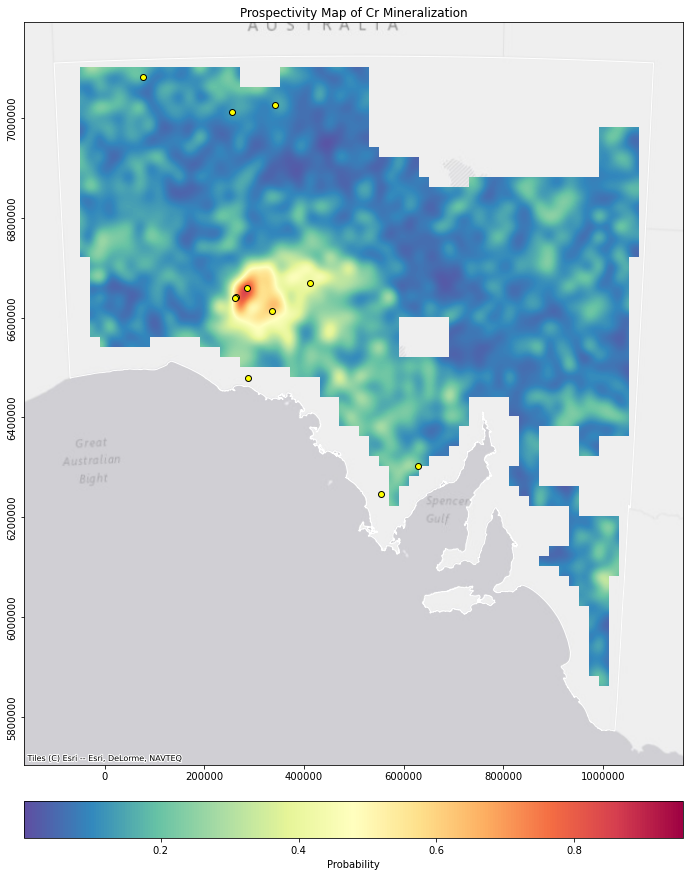

In [36]:
# plot an interpolated probability map
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(deposit_x, deposit_y, color='yellow', edgecolors='black')
sa_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
plt.imshow(probabilities_2d, cmap='Spectral_r', origin='lower', interpolation='bicubic',
           extent=(sample_frame.left, sample_frame.right, sample_frame.bottom, sample_frame.top))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Prospectivity Map of {commodity} Mineralisation')
plt.show()

In [37]:
# export the map to a GeoTIFF file
xmin, ymin, xmax, ymax = [x.min(), y.min(), x.max(), y.max()]
geotransform = (xmin, dist_x, 0, ymax, 0, -dist_y)
suffix = input('Enter a number to add to the end of the file name: ')
map_file = f'./{commodity}/probabiliy_map_avg_{commodity}_{suffix}.tiff'

driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(map_file, nx, ny, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(7853)
dataset.SetProjection(srs.ExportToWkt())

dataset.GetRasterBand(1).WriteArray(probabilities_2d_ud)
dataset.FlushCache()
dataset = None

Enter a number to add to the end of the file name: 01


##### Variance

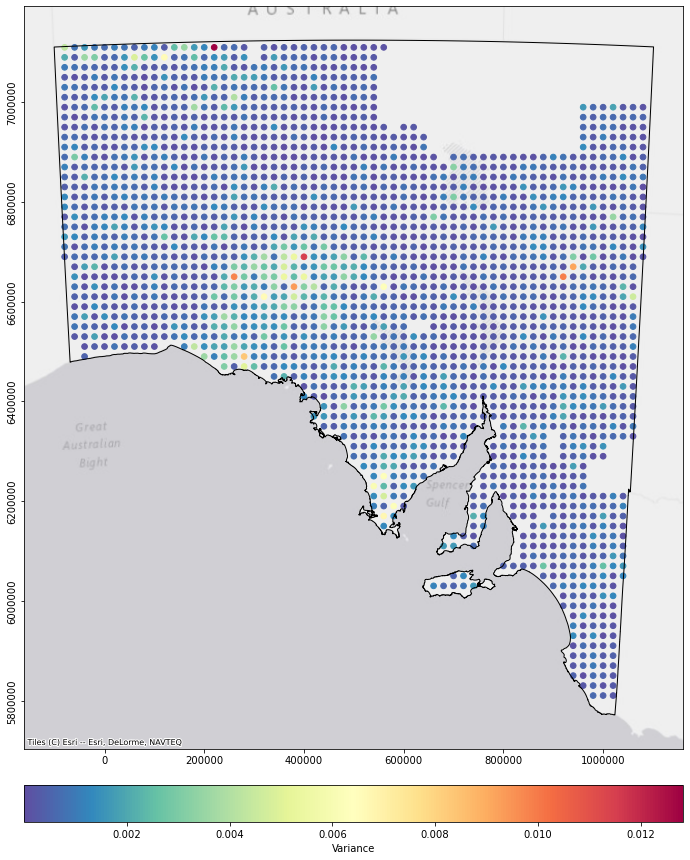

In [38]:
plot_x = sample_data['X']
plot_y = sample_data['Y']

# plot the variance map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(plot_x, plot_y, 32., c=point_probs_var, cmap='Spectral_r')

sa_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))

# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Variance', cax=cax)
plt.show()

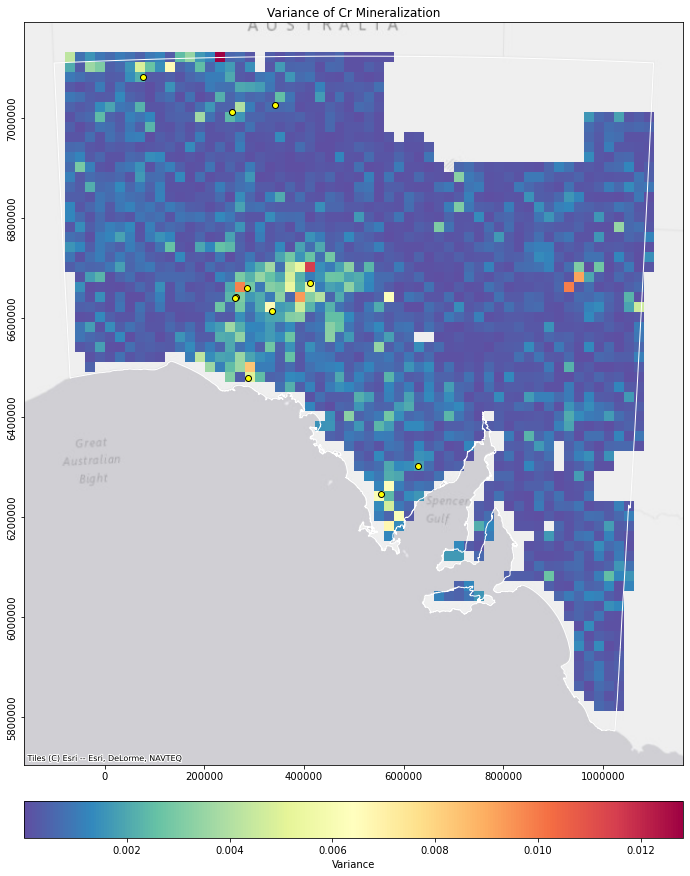

In [39]:
# create a variance map using the target points
probabilities_var = []
count = 0

for mask in sample_mask:
    if mask:
        probabilities_var.append(point_probs_var[count])
        count += 1
    else:
        probabilities_var.append(np.nan)

probabilities_var_2d = np.reshape(probabilities_var, (ny, nx))
probabilities_var_2d_ud = np.flipud(np.reshape(probabilities_var, (ny, nx)))

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(deposit_x, deposit_y, color='yellow', edgecolors='black')
sa_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.imshow(probabilities_var_2d, cmap='Spectral_r', origin='lower', interpolation='none',
           extent=(sample_frame.left, sample_frame.right, sample_frame.bottom, sample_frame.top))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Variance', cax=cax)
ax.set_title(f'Variance of {commodity} Mineralisation')
plt.show()

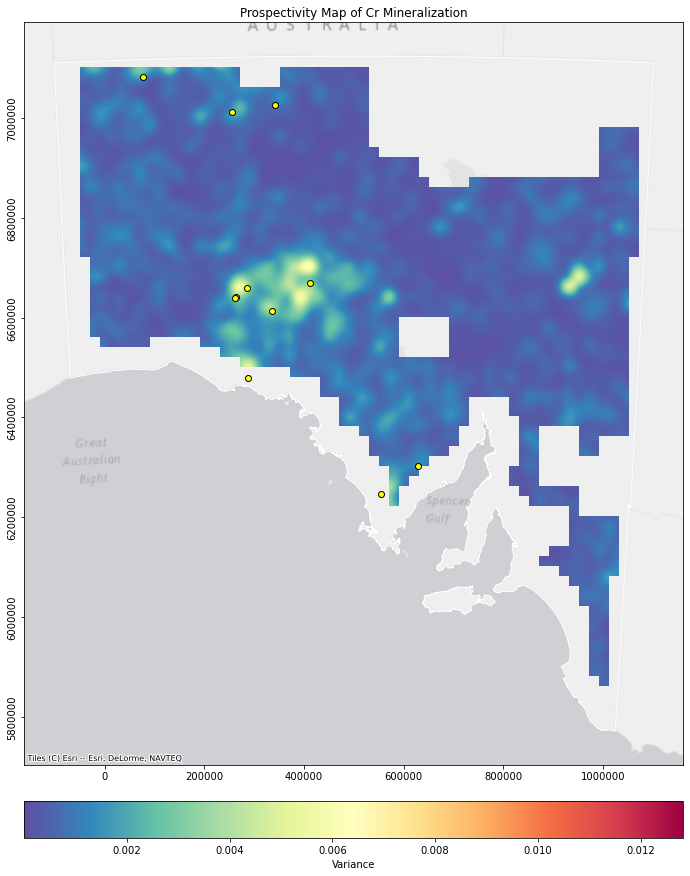

In [40]:
# plot an interpolated variance map
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(deposit_x, deposit_y, color='yellow', edgecolors='black')
sa_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
plt.imshow(probabilities_var_2d, cmap='Spectral_r', origin='lower', interpolation='bicubic',
           extent=(sample_frame.left, sample_frame.right, sample_frame.bottom, sample_frame.top))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Variance', cax=cax)
ax.set_title(f'Prospectivity Map of {commodity} Mineralisation')
plt.show()

In [41]:
# export the map to a GeoTIFF file
xmin, ymin, xmax, ymax = [x.min(), y.min(), x.max(), y.max()]
geotransform = (xmin, dist_x, 0, ymax, 0, -dist_y)
num = input('Enter a number to add to the end of the file name: ')
map_file = f'./{commodity}/probabiliy_map_var_{commodity}_{num}.tiff'

driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(map_file, nx, ny, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(7853)
dataset.SetProjection(srs.ExportToWkt())

dataset.GetRasterBand(1).WriteArray(probabilities_var_2d_ud)
dataset.FlushCache()
dataset = None

Enter a number to add to the end of the file name: 01


#### Gawler Craton
##### Probability

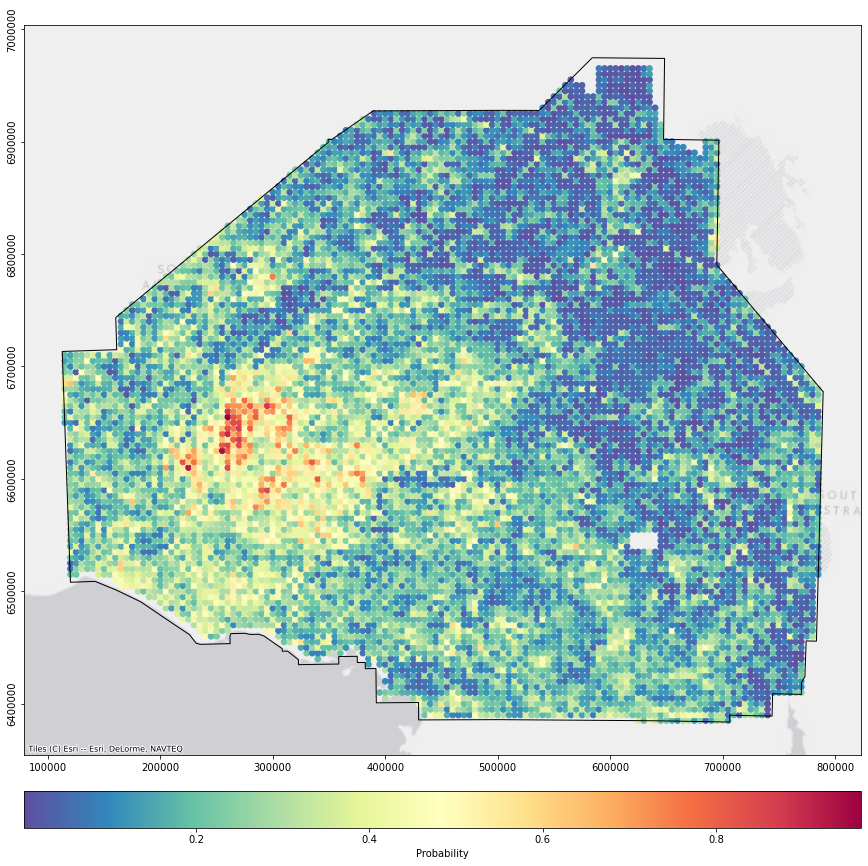

In [42]:
plot_x_gc = sample_data_gc['X']
plot_y_gc = sample_data_gc['Y']

# plot the probability map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(plot_x_gc, plot_y_gc, 32., c=point_probs_gc_mean, cmap='Spectral_r')

gc_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))

# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
plt.show()

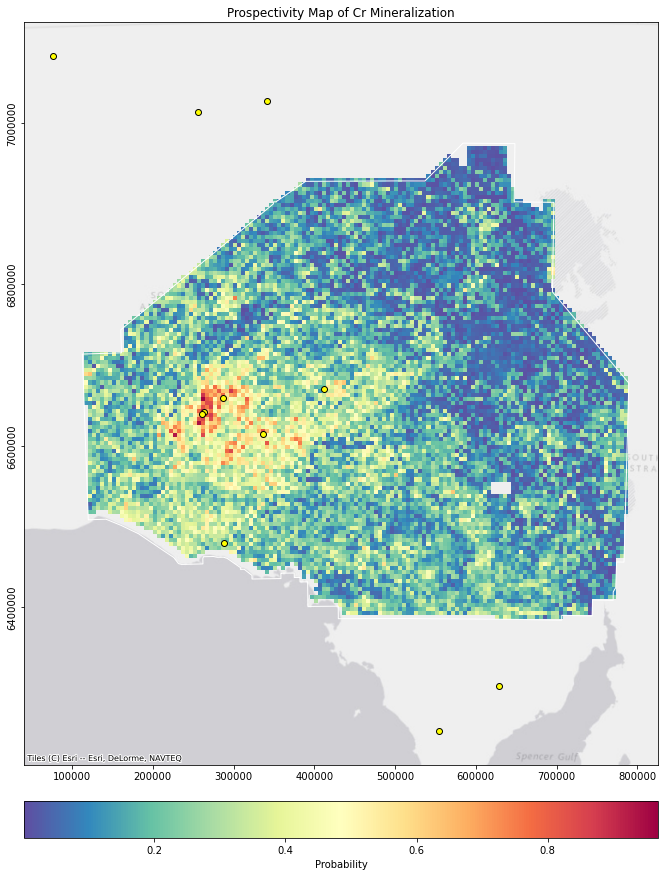

In [43]:
# create a probability map using the target points
probabilities_gc = []
count = 0

for mask in sample_mask_gc:
    if mask:
        probabilities_gc.append(point_probs_gc_mean[count])
        count += 1
    else:
        probabilities_gc.append(np.nan)

probabilities_2d_gc = np.reshape(probabilities_gc, (ny_gc, nx_gc))
probabilities_2d_ud_gc = np.flipud(np.reshape(probabilities_gc, (ny_gc, nx_gc)))

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(deposit_x, deposit_y, color='yellow', edgecolors='black')
gc_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
plt.imshow(probabilities_2d_gc, cmap='Spectral_r', origin='lower', interpolation='none',
           extent=(sample_frame_gc.left, sample_frame_gc.right, sample_frame_gc.bottom, sample_frame_gc.top))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Prospectivity Map of {commodity} Mineralisation')
plt.show()

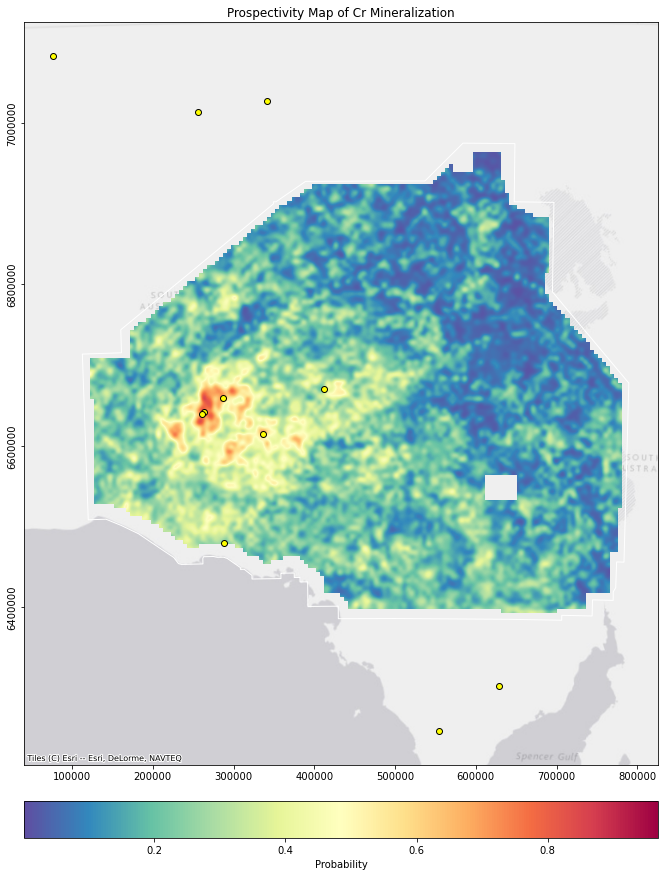

In [44]:
# plot an interpolated probability map
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(deposit_x, deposit_y, color='yellow', edgecolors='black')
gc_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.imshow(probabilities_2d_gc, cmap='Spectral_r', origin='lower', interpolation='bicubic',
           extent=(sample_frame_gc.left, sample_frame_gc.right, sample_frame_gc.bottom, sample_frame_gc.top))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Prospectivity Map of {commodity} Mineralisation')
plt.show()

In [45]:
# export the map to a GeoTIFF file
xmin_gc, ymin_gc, xmax_gc, ymax_gc = [x_gc.min(), y_gc.min(), x_gc.max(), y_gc.max()]
geotransform_gc = (xmin_gc, dist_x_gc, 0, ymax_gc, 0, -dist_y_gc)
num = input('Enter a number to add to the end of the file name: ')
map_file_gc = f'./{commodity}/probabiliy_map_avg_gc_{commodity}_{num}.tiff'

driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(map_file_gc, nx_gc, ny_gc, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform_gc)
srs = osr.SpatialReference()
srs.ImportFromEPSG(7853)
dataset.SetProjection(srs.ExportToWkt())

dataset.GetRasterBand(1).WriteArray(probabilities_2d_ud_gc)
dataset.FlushCache()
dataset = None

Enter a number to add to the end of the file name: 01


##### Variance

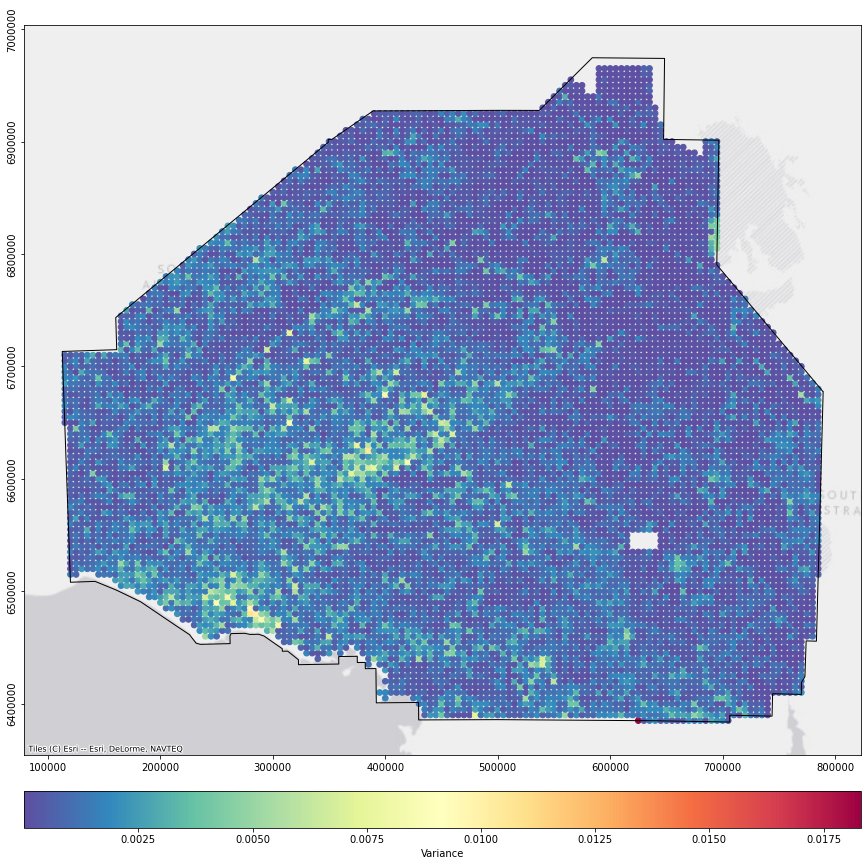

In [46]:
plot_x_gc = sample_data_gc['X']
plot_y_gc = sample_data_gc['Y']

# plot the variance map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(plot_x_gc, plot_y_gc, 32., c=point_probs_var_gc, cmap='Spectral_r')

gc_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))

# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Variance', cax=cax)
plt.show()

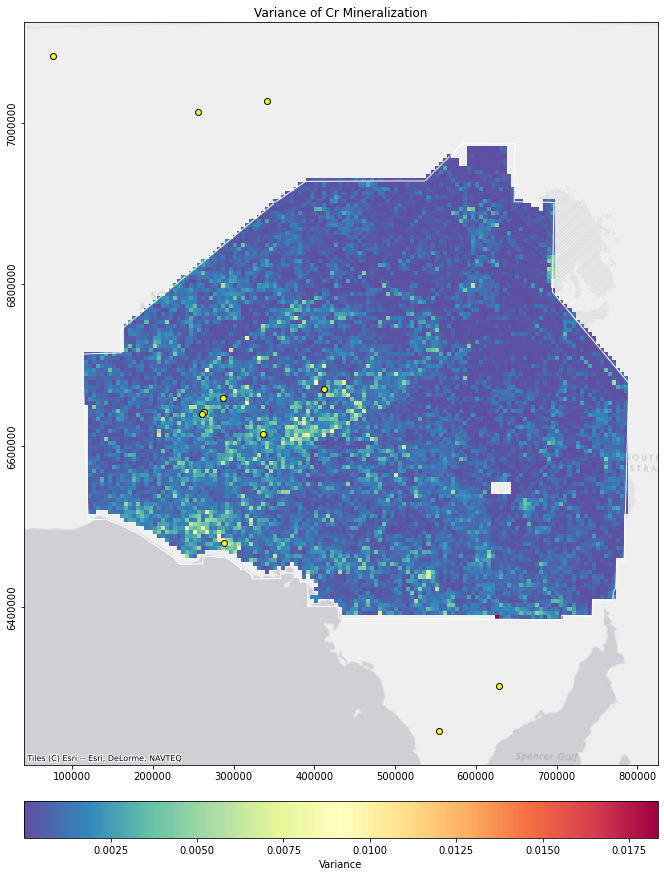

In [47]:
# create a variance map using the target points
probabilities_var_gc = []
count = 0

for mask in sample_mask_gc:
    if mask:
        probabilities_var_gc.append(point_probs_var_gc[count])
        count += 1
    else:
        probabilities_var_gc.append(np.nan)

probabilities_var_2d_gc = np.reshape(probabilities_var_gc, (ny_gc, nx_gc))
probabilities_var_2d_ud_gc = np.flipud(np.reshape(probabilities_var_gc, (ny_gc, nx_gc)))

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(deposit_x, deposit_y, color='yellow', edgecolors='black')
gc_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
plt.imshow(probabilities_var_2d_gc, cmap='Spectral_r', origin='lower', interpolation='none',
           extent=(sample_frame_gc.left, sample_frame_gc.right, sample_frame_gc.bottom, sample_frame_gc.top))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Variance', cax=cax)
ax.set_title(f'Variance of {commodity} Mineralisation')
plt.show()

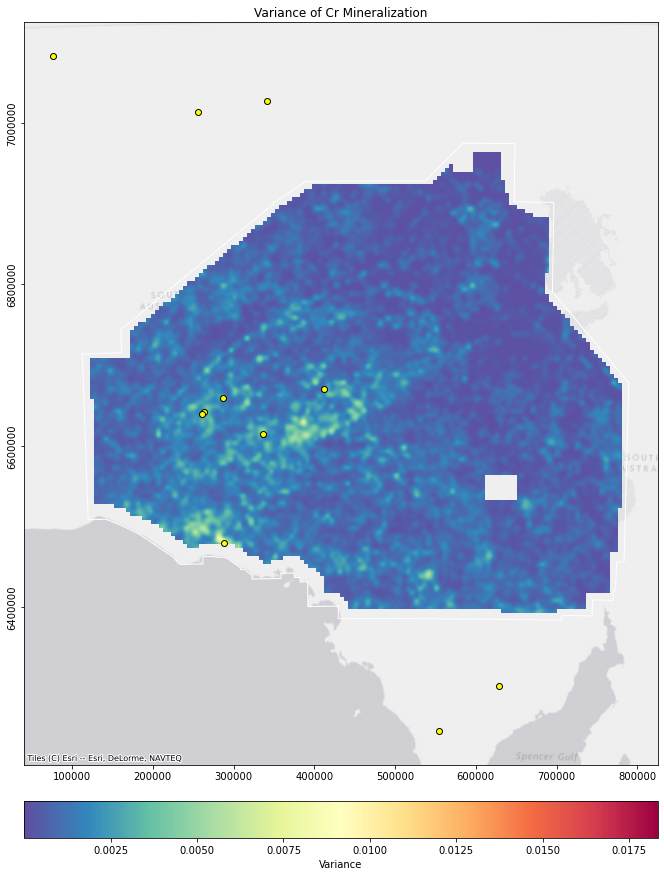

In [48]:
# plot an interpolated variance map
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(deposit_x, deposit_y, color='yellow', edgecolors='black')
gc_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:7853', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.imshow(probabilities_var_2d_gc, cmap='Spectral_r', origin='lower', interpolation='bicubic',
           extent=(sample_frame_gc.left, sample_frame_gc.right, sample_frame_gc.bottom, sample_frame_gc.top))

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Variance', cax=cax)
ax.set_title(f'Variance of {commodity} Mineralisation')
plt.show()

In [49]:
# export the map to a GeoTIFF file
xmin_gc, ymin_gc, xmax_gc, ymax_gc = [x_gc.min(), y_gc.min(), x_gc.max(), y_gc.max()]
geotransform_gc = (xmin_gc, dist_x_gc, 0, ymax_gc, 0, -dist_y_gc)
num = input('Enter a number to add to the end of the file name: ')
map_file_gc = f'./{commodity}/probabiliy_map_var_gc_{commodity}_{num}.tiff'

driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(map_file_gc, nx_gc, ny_gc, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform_gc)
srs = osr.SpatialReference()
srs.ImportFromEPSG(7853)
dataset.SetProjection(srs.ExportToWkt())

dataset.GetRasterBand(1).WriteArray(probabilities_var_2d_ud_gc)
dataset.FlushCache()
dataset = None

Enter a number to add to the end of the file name: 01
